<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys

**Import utility functions from Pytorch**

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

**Enable GPU**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


**Declare parameters**

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 1

# Input data

**Download Food256 dataset**

To extend the food classification into food detection I will need a dataset that includes bounding boxes, thus I have used food-256 including 256 different classes that contain atleast 100 images each. If the given directory not found then dataset is downloaded and extracted.

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

if not os.path.exists(FOOD256_DIR):
  print("Downloading Food-256 dataset... ", end="")
  !wget http://foodcam.mobi/dataset256.zip
  print("Done")


  print("Extracting data... ", end="")
  !unzip dataset256.zip
  print("Done")

**Format dataset for extraction**

Extract images into one directory called 'images' and create a corresponding label file containing 'class x y width height' in seperate 'labels' directory. Then create train.txt and val.txt files containing image paths.

In [6]:
IMAGES_DIR = os.path.join(FOOD256_DIR, "images")
LABELS_DIR = os.path.join(FOOD256_DIR, "labels")

if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    os.makedirs(LABELS_DIR)

    classes = [str(i) for i in range(1, 257)]

    for class_id in classes:
        class_path = os.path.join(FOOD256_DIR, class_id, "bb_info.txt")
        with open(class_path, 'r') as file:
            # ignore headers
            file.readline()
            for line in file.readlines():
                line = line.strip().split()
                img_path = os.path.join(FOOD256_DIR, class_id, line[0]+".jpg")

                # copy img to images directory
                dest = os.path.join(IMAGES_DIR, line[0]+".jpg")
                shutil.copy(img_path, dest)

                # copy bounding box annotation into txt file in labels directory
                with open(os.path.join(LABELS_DIR, line[0]+".txt"), 'w') as box_file:
                    box = class_id + " " + " ".join(line[1:])
                    box_file.write(box)

**Define FoodDataset class as subclass of Dataset**

In [7]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.classes = []
        with open(os.path.join(root, "category.txt"), 'r') as file:
            file.readline()
            for line in file.readlines():
                self.classes.append(line.strip().split("\t")[1])
        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "images", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        #label
        lbl_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        with open(lbl_path, 'r') as file:
            line = file.read().split()
            
        lbl = int(line[0]) - 1
            
        x1 = float(line[1])
        y1 = float(line[2])
        x2 = float(line[3])
        y2 = float(line[4])

        target = {
            "image_id": torch.as_tensor([index]),
            "labels": torch.as_tensor([lbl], dtype=torch.int64),
            "boxes": torch.as_tensor([[x1, y1, x2, y2]], dtype=torch.float32),
            "area": torch.as_tensor([(x2-x1)*(y2-y1)]),
            "iscrowd": torch.as_tensor([0], dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

**Format images**

In [8]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = img / 255
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

food_raw = FoodDataset(FOOD256_DIR, transform=transform)
food_size = len(food_raw)

class_names = food_raw.classes

**Split dataset into train and val sets**

In [9]:
indices = torch.randperm(food_size).tolist()

# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

# take 80% as training
train_raw = torch.utils.data.Subset(food_raw, indices[:int(0.8*food_size)])
train_size = len(train_raw)
train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# take 20% as validation
val_raw = torch.utils.data.Subset(food_raw, indices[int(0.8*food_size):])
val_size = len(val_raw)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=max(1, BATCH_SIZE//2), shuffle=True, collate_fn=collate_fn)

**Show example image with bounding boxes**

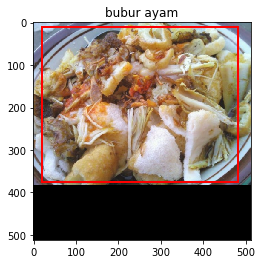

In [10]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(train_size)
img = train_raw[i][0].numpy()
img = np.transpose(img, (1,2,0))
img = img * 255
img = np.clip(img, 0, 1)
plt.imshow(img)

# draw bounding box
x1, y1, x2, y2 = train_raw[i][1]["boxes"][0]
box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
axis.add_patch(box)

plt.title(class_names[train_raw[i][1]["labels"][0]])

fig

# Model

**Fetch pretrained wide resnet on food101 dataset as backbone**

In [11]:
BACKBONE_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "fine_tuning_wideres.pt")

print("Fetching pretrained backbone... ", end="")
backbone = torchvision.models.wide_resnet101_2(pretrained=False)

# replace classification head
num_features = backbone.fc.in_features
backbone.fc = torch.nn.Linear(num_features, 101)

# load trained weights
backbone.load_state_dict(torch.load(BACKBONE_PATH))

# remove classification head
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048

print("done")

Fetching pretrained backbone... done


**Create Faster R-CNN from wide resnet backbone**

In [12]:
print("Creating R-CNN... ", end="")
model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names))

model = model.to(device)
print("done")

Creating R-CNN... done


# Train

**Declare optimizer**

In [13]:
learning_rate = 0.01

# fetch trainable parameters for transfer learning(where requires_grad = true)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)

**Train model**

In [14]:
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    evaluate(model, val_loader, device)


Epoch: [5]  [    0/23117]  eta: 12:18:45  lr: 0.010000  loss: 15.1717 (15.1717)  loss_classifier: 5.5978 (5.5978)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.6115 (0.6115)  loss_rpn_box_reg: 8.9624 (8.9624)  time: 1.9175  data: 0.0905  max mem: 4262
Epoch: [5]  [   10/23117]  eta: 4:32:26  lr: 0.010000  loss: 5.9187 (7.7618)  loss_classifier: 0.5604 (1.4514)  loss_box_reg: 0.0061 (0.0173)  loss_objectness: 0.3257 (0.3544)  loss_rpn_box_reg: 5.4309 (5.9387)  time: 0.7074  data: 0.0923  max mem: 4926
Epoch: [5]  [   20/23117]  eta: 4:11:08  lr: 0.010000  loss: 5.8056 (6.5430)  loss_classifier: 0.2556 (0.8481)  loss_box_reg: 0.0153 (0.0250)  loss_objectness: 0.2839 (0.3128)  loss_rpn_box_reg: 5.2674 (5.3571)  time: 0.5892  data: 0.0944  max mem: 4926
Epoch: [5]  [   30/23117]  eta: 4:04:30  lr: 0.010000  loss: 4.8225 (5.7609)  loss_classifier: 0.1384 (0.6371)  loss_box_reg: 0.0284 (0.0286)  loss_objectness: 0.2164 (0.2783)  loss_rpn_box_reg: 4.2083 (4.8169)  time: 0.5958  data: 0.1

Epoch: [5]  [  330/23117]  eta: 3:50:22  lr: 0.010000  loss: 1.6281 (2.6285)  loss_classifier: 0.0964 (0.1584)  loss_box_reg: 0.0317 (0.0324)  loss_objectness: 0.0973 (0.1688)  loss_rpn_box_reg: 1.3221 (2.2689)  time: 0.6157  data: 0.0860  max mem: 4926
Epoch: [5]  [  340/23117]  eta: 3:50:15  lr: 0.010000  loss: 1.8278 (2.6124)  loss_classifier: 0.1001 (0.1569)  loss_box_reg: 0.0343 (0.0324)  loss_objectness: 0.0973 (0.1681)  loss_rpn_box_reg: 1.5896 (2.2550)  time: 0.6120  data: 0.0821  max mem: 4926
Epoch: [5]  [  350/23117]  eta: 3:50:22  lr: 0.010000  loss: 1.8201 (2.5839)  loss_classifier: 0.0975 (0.1554)  loss_box_reg: 0.0366 (0.0325)  loss_objectness: 0.0978 (0.1664)  loss_rpn_box_reg: 1.5581 (2.2295)  time: 0.6159  data: 0.0856  max mem: 4926
Epoch: [5]  [  360/23117]  eta: 3:50:13  lr: 0.010000  loss: 1.7719 (2.5636)  loss_classifier: 0.0977 (0.1541)  loss_box_reg: 0.0389 (0.0327)  loss_objectness: 0.0860 (0.1648)  loss_rpn_box_reg: 1.5055 (2.2120)  time: 0.6149  data: 0.0848

Epoch: [5]  [  660/23117]  eta: 3:47:10  lr: 0.010000  loss: 1.6410 (2.2157)  loss_classifier: 0.1035 (0.1288)  loss_box_reg: 0.0350 (0.0316)  loss_objectness: 0.1128 (0.1563)  loss_rpn_box_reg: 1.3424 (1.8990)  time: 0.6042  data: 0.0749  max mem: 4926
Epoch: [5]  [  670/23117]  eta: 3:47:04  lr: 0.010000  loss: 1.5291 (2.2075)  loss_classifier: 0.1111 (0.1287)  loss_box_reg: 0.0381 (0.0317)  loss_objectness: 0.1194 (0.1560)  loss_rpn_box_reg: 1.2803 (1.8911)  time: 0.6052  data: 0.0714  max mem: 4926
Epoch: [5]  [  680/23117]  eta: 3:47:03  lr: 0.010000  loss: 1.5652 (2.1984)  loss_classifier: 0.1170 (0.1283)  loss_box_reg: 0.0321 (0.0317)  loss_objectness: 0.1057 (0.1553)  loss_rpn_box_reg: 1.3137 (1.8831)  time: 0.6143  data: 0.0758  max mem: 4926
Epoch: [5]  [  690/23117]  eta: 3:46:56  lr: 0.010000  loss: 1.5762 (2.1934)  loss_classifier: 0.1013 (0.1278)  loss_box_reg: 0.0320 (0.0317)  loss_objectness: 0.1255 (0.1555)  loss_rpn_box_reg: 1.3392 (1.8784)  time: 0.6133  data: 0.0785

Epoch: [5]  [  990/23117]  eta: 3:43:49  lr: 0.010000  loss: 1.3054 (1.9973)  loss_classifier: 0.0923 (0.1193)  loss_box_reg: 0.0278 (0.0315)  loss_objectness: 0.0940 (0.1470)  loss_rpn_box_reg: 1.0758 (1.6995)  time: 0.5987  data: 0.0648  max mem: 4926
Epoch: [5]  [ 1000/23117]  eta: 3:43:42  lr: 0.010000  loss: 1.1978 (1.9915)  loss_classifier: 0.1109 (0.1191)  loss_box_reg: 0.0320 (0.0315)  loss_objectness: 0.0886 (0.1469)  loss_rpn_box_reg: 0.9763 (1.6940)  time: 0.5998  data: 0.0664  max mem: 4926
Epoch: [5]  [ 1010/23117]  eta: 3:43:35  lr: 0.010000  loss: 1.1437 (1.9851)  loss_classifier: 0.1076 (0.1191)  loss_box_reg: 0.0341 (0.0315)  loss_objectness: 0.0798 (0.1464)  loss_rpn_box_reg: 0.9021 (1.6882)  time: 0.6021  data: 0.0691  max mem: 4926
Epoch: [5]  [ 1020/23117]  eta: 3:43:29  lr: 0.010000  loss: 1.2755 (1.9791)  loss_classifier: 0.1033 (0.1190)  loss_box_reg: 0.0330 (0.0316)  loss_objectness: 0.0798 (0.1459)  loss_rpn_box_reg: 1.1120 (1.6825)  time: 0.6035  data: 0.0710

Epoch: [5]  [ 1320/23117]  eta: 3:39:35  lr: 0.010000  loss: 1.1542 (1.8604)  loss_classifier: 0.0927 (0.1140)  loss_box_reg: 0.0288 (0.0311)  loss_objectness: 0.0908 (0.1409)  loss_rpn_box_reg: 0.9448 (1.5743)  time: 0.5917  data: 0.0617  max mem: 4926
Epoch: [5]  [ 1330/23117]  eta: 3:39:28  lr: 0.010000  loss: 1.1413 (1.8562)  loss_classifier: 0.1030 (0.1139)  loss_box_reg: 0.0302 (0.0311)  loss_objectness: 0.1028 (0.1409)  loss_rpn_box_reg: 0.9262 (1.5702)  time: 0.5932  data: 0.0636  max mem: 4926
Epoch: [5]  [ 1340/23117]  eta: 3:39:18  lr: 0.010000  loss: 1.2479 (1.8554)  loss_classifier: 0.0934 (0.1138)  loss_box_reg: 0.0315 (0.0311)  loss_objectness: 0.0855 (0.1409)  loss_rpn_box_reg: 1.0626 (1.5696)  time: 0.5897  data: 0.0599  max mem: 4926
Epoch: [5]  [ 1350/23117]  eta: 3:39:09  lr: 0.010000  loss: 1.2488 (1.8511)  loss_classifier: 0.0850 (0.1135)  loss_box_reg: 0.0243 (0.0310)  loss_objectness: 0.0982 (0.1414)  loss_rpn_box_reg: 0.9627 (1.5652)  time: 0.5847  data: 0.0548

Epoch: [5]  [ 1650/23117]  eta: 3:35:11  lr: 0.010000  loss: 1.2055 (1.7648)  loss_classifier: 0.0929 (0.1105)  loss_box_reg: 0.0253 (0.0307)  loss_objectness: 0.1055 (0.1399)  loss_rpn_box_reg: 0.9787 (1.4838)  time: 0.5836  data: 0.0535  max mem: 4926
Epoch: [5]  [ 1660/23117]  eta: 3:35:04  lr: 0.010000  loss: 1.2812 (1.7626)  loss_classifier: 0.0874 (0.1104)  loss_box_reg: 0.0239 (0.0307)  loss_objectness: 0.1212 (0.1401)  loss_rpn_box_reg: 0.9851 (1.4814)  time: 0.5858  data: 0.0557  max mem: 4926
Epoch: [5]  [ 1670/23117]  eta: 3:34:58  lr: 0.010000  loss: 1.2592 (1.7593)  loss_classifier: 0.1064 (0.1103)  loss_box_reg: 0.0330 (0.0307)  loss_objectness: 0.1211 (0.1401)  loss_rpn_box_reg: 0.9819 (1.4782)  time: 0.5950  data: 0.0647  max mem: 4926
Epoch: [5]  [ 1680/23117]  eta: 3:34:51  lr: 0.010000  loss: 1.1631 (1.7569)  loss_classifier: 0.0945 (0.1102)  loss_box_reg: 0.0248 (0.0306)  loss_objectness: 0.1060 (0.1400)  loss_rpn_box_reg: 0.8792 (1.4760)  time: 0.5971  data: 0.0669

Epoch: [5]  [ 1980/23117]  eta: 3:31:01  lr: 0.010000  loss: 1.1078 (1.6875)  loss_classifier: 0.0977 (0.1073)  loss_box_reg: 0.0283 (0.0301)  loss_objectness: 0.0786 (0.1362)  loss_rpn_box_reg: 0.9502 (1.4140)  time: 0.5772  data: 0.0464  max mem: 4926
Epoch: [5]  [ 1990/23117]  eta: 3:30:53  lr: 0.010000  loss: 1.1140 (1.6859)  loss_classifier: 0.1024 (0.1073)  loss_box_reg: 0.0318 (0.0301)  loss_objectness: 0.0962 (0.1360)  loss_rpn_box_reg: 0.9186 (1.4125)  time: 0.5780  data: 0.0472  max mem: 4926
Epoch: [5]  [ 2000/23117]  eta: 3:30:46  lr: 0.010000  loss: 1.1548 (1.6829)  loss_classifier: 0.0896 (0.1072)  loss_box_reg: 0.0220 (0.0300)  loss_objectness: 0.0956 (0.1359)  loss_rpn_box_reg: 0.9186 (1.4098)  time: 0.5839  data: 0.0524  max mem: 4926
Epoch: [5]  [ 2010/23117]  eta: 3:30:39  lr: 0.010000  loss: 1.1275 (1.6800)  loss_classifier: 0.0816 (0.1070)  loss_box_reg: 0.0215 (0.0300)  loss_objectness: 0.0951 (0.1358)  loss_rpn_box_reg: 0.8957 (1.4072)  time: 0.5899  data: 0.0585

Epoch: [5]  [ 2310/23117]  eta: 3:27:19  lr: 0.010000  loss: 1.1397 (1.6401)  loss_classifier: 0.0905 (0.1045)  loss_box_reg: 0.0202 (0.0293)  loss_objectness: 0.1082 (0.1348)  loss_rpn_box_reg: 0.9310 (1.3714)  time: 0.5884  data: 0.0568  max mem: 4926
Epoch: [5]  [ 2320/23117]  eta: 3:27:13  lr: 0.010000  loss: 1.0676 (1.6377)  loss_classifier: 0.0768 (0.1044)  loss_box_reg: 0.0186 (0.0293)  loss_objectness: 0.0738 (0.1345)  loss_rpn_box_reg: 0.8989 (1.3695)  time: 0.6004  data: 0.0683  max mem: 4926
Epoch: [5]  [ 2330/23117]  eta: 3:27:07  lr: 0.010000  loss: 1.1094 (1.6379)  loss_classifier: 0.0774 (0.1043)  loss_box_reg: 0.0214 (0.0293)  loss_objectness: 0.0754 (0.1345)  loss_rpn_box_reg: 0.9118 (1.3698)  time: 0.5945  data: 0.0631  max mem: 4926
Epoch: [5]  [ 2340/23117]  eta: 3:27:00  lr: 0.010000  loss: 1.2434 (1.6360)  loss_classifier: 0.0903 (0.1043)  loss_box_reg: 0.0246 (0.0293)  loss_objectness: 0.0948 (0.1344)  loss_rpn_box_reg: 0.9727 (1.3680)  time: 0.5892  data: 0.0581

Epoch: [5]  [ 2640/23117]  eta: 3:23:27  lr: 0.010000  loss: 0.9365 (1.5875)  loss_classifier: 0.0960 (0.1026)  loss_box_reg: 0.0282 (0.0288)  loss_objectness: 0.0832 (0.1325)  loss_rpn_box_reg: 0.6996 (1.3235)  time: 0.5746  data: 0.0450  max mem: 4926
Epoch: [5]  [ 2650/23117]  eta: 3:23:20  lr: 0.010000  loss: 0.9504 (1.5855)  loss_classifier: 0.0885 (0.1025)  loss_box_reg: 0.0233 (0.0288)  loss_objectness: 0.0896 (0.1326)  loss_rpn_box_reg: 0.7043 (1.3216)  time: 0.5785  data: 0.0489  max mem: 4926
Epoch: [5]  [ 2660/23117]  eta: 3:23:13  lr: 0.010000  loss: 1.0300 (1.5836)  loss_classifier: 0.0903 (0.1025)  loss_box_reg: 0.0230 (0.0288)  loss_objectness: 0.0896 (0.1326)  loss_rpn_box_reg: 0.8192 (1.3197)  time: 0.5778  data: 0.0482  max mem: 4926
Epoch: [5]  [ 2670/23117]  eta: 3:23:05  lr: 0.010000  loss: 1.0701 (1.5818)  loss_classifier: 0.0903 (0.1025)  loss_box_reg: 0.0250 (0.0288)  loss_objectness: 0.0790 (0.1326)  loss_rpn_box_reg: 0.8722 (1.3180)  time: 0.5728  data: 0.0429

Epoch: [5]  [ 2970/23117]  eta: 3:19:39  lr: 0.010000  loss: 1.0799 (1.5528)  loss_classifier: 0.0871 (0.1012)  loss_box_reg: 0.0245 (0.0284)  loss_objectness: 0.0801 (0.1313)  loss_rpn_box_reg: 0.8282 (1.2920)  time: 0.5861  data: 0.0564  max mem: 4926
Epoch: [5]  [ 2980/23117]  eta: 3:19:32  lr: 0.010000  loss: 1.2620 (1.5519)  loss_classifier: 0.0950 (0.1012)  loss_box_reg: 0.0266 (0.0284)  loss_objectness: 0.0896 (0.1312)  loss_rpn_box_reg: 0.8864 (1.2911)  time: 0.5865  data: 0.0553  max mem: 4926
Epoch: [5]  [ 2990/23117]  eta: 3:19:26  lr: 0.010000  loss: 1.0182 (1.5494)  loss_classifier: 0.0801 (0.1011)  loss_box_reg: 0.0204 (0.0284)  loss_objectness: 0.0795 (0.1311)  loss_rpn_box_reg: 0.7720 (1.2889)  time: 0.5887  data: 0.0555  max mem: 4926
Epoch: [5]  [ 3000/23117]  eta: 3:19:19  lr: 0.010000  loss: 1.0182 (1.5484)  loss_classifier: 0.0682 (0.1010)  loss_box_reg: 0.0197 (0.0283)  loss_objectness: 0.0795 (0.1313)  loss_rpn_box_reg: 0.7261 (1.2877)  time: 0.5887  data: 0.0565

Epoch: [5]  [ 3300/23117]  eta: 3:15:56  lr: 0.010000  loss: 1.0462 (1.5139)  loss_classifier: 0.0771 (0.1003)  loss_box_reg: 0.0184 (0.0281)  loss_objectness: 0.0844 (0.1301)  loss_rpn_box_reg: 0.7487 (1.2554)  time: 0.5745  data: 0.0438  max mem: 4926
Epoch: [5]  [ 3310/23117]  eta: 3:15:49  lr: 0.010000  loss: 0.9328 (1.5122)  loss_classifier: 0.0705 (0.1002)  loss_box_reg: 0.0184 (0.0281)  loss_objectness: 0.0824 (0.1300)  loss_rpn_box_reg: 0.7487 (1.2539)  time: 0.5731  data: 0.0430  max mem: 4926
Epoch: [5]  [ 3320/23117]  eta: 3:15:43  lr: 0.010000  loss: 0.9685 (1.5110)  loss_classifier: 0.0775 (0.1002)  loss_box_reg: 0.0205 (0.0280)  loss_objectness: 0.0755 (0.1299)  loss_rpn_box_reg: 0.7894 (1.2529)  time: 0.5828  data: 0.0530  max mem: 4926
Epoch: [5]  [ 3330/23117]  eta: 3:15:36  lr: 0.010000  loss: 1.0052 (1.5100)  loss_classifier: 0.0775 (0.1001)  loss_box_reg: 0.0241 (0.0280)  loss_objectness: 0.0773 (0.1297)  loss_rpn_box_reg: 0.8395 (1.2522)  time: 0.5817  data: 0.0518

Epoch: [5]  [ 3630/23117]  eta: 3:12:18  lr: 0.010000  loss: 1.1118 (1.4875)  loss_classifier: 0.0781 (0.0984)  loss_box_reg: 0.0216 (0.0274)  loss_objectness: 0.0753 (0.1290)  loss_rpn_box_reg: 0.9252 (1.2327)  time: 0.5817  data: 0.0518  max mem: 4926
Epoch: [5]  [ 3640/23117]  eta: 3:12:11  lr: 0.010000  loss: 1.1789 (1.4878)  loss_classifier: 0.0839 (0.0984)  loss_box_reg: 0.0261 (0.0274)  loss_objectness: 0.0942 (0.1291)  loss_rpn_box_reg: 0.9463 (1.2330)  time: 0.5763  data: 0.0460  max mem: 4926
Epoch: [5]  [ 3650/23117]  eta: 3:12:05  lr: 0.010000  loss: 1.0371 (1.4863)  loss_classifier: 0.0774 (0.0983)  loss_box_reg: 0.0165 (0.0274)  loss_objectness: 0.0944 (0.1291)  loss_rpn_box_reg: 0.8269 (1.2316)  time: 0.5829  data: 0.0523  max mem: 4926
Epoch: [5]  [ 3660/23117]  eta: 3:11:59  lr: 0.010000  loss: 0.9593 (1.4851)  loss_classifier: 0.0776 (0.0983)  loss_box_reg: 0.0195 (0.0274)  loss_objectness: 0.0891 (0.1290)  loss_rpn_box_reg: 0.7606 (1.2305)  time: 0.5834  data: 0.0532

Epoch: [5]  [ 3960/23117]  eta: 3:08:43  lr: 0.010000  loss: 0.9863 (1.4563)  loss_classifier: 0.0870 (0.0968)  loss_box_reg: 0.0227 (0.0268)  loss_objectness: 0.0943 (0.1276)  loss_rpn_box_reg: 0.7728 (1.2051)  time: 0.5791  data: 0.0493  max mem: 4926
Epoch: [5]  [ 3970/23117]  eta: 3:08:36  lr: 0.010000  loss: 0.9863 (1.4555)  loss_classifier: 0.0692 (0.0967)  loss_box_reg: 0.0181 (0.0268)  loss_objectness: 0.0971 (0.1276)  loss_rpn_box_reg: 0.8043 (1.2044)  time: 0.5797  data: 0.0498  max mem: 4926
Epoch: [5]  [ 3980/23117]  eta: 3:08:30  lr: 0.010000  loss: 0.9719 (1.4541)  loss_classifier: 0.0672 (0.0967)  loss_box_reg: 0.0167 (0.0268)  loss_objectness: 0.0893 (0.1275)  loss_rpn_box_reg: 0.7813 (1.2032)  time: 0.5808  data: 0.0503  max mem: 4926
Epoch: [5]  [ 3990/23117]  eta: 3:08:23  lr: 0.010000  loss: 0.9719 (1.4550)  loss_classifier: 0.0683 (0.0966)  loss_box_reg: 0.0162 (0.0267)  loss_objectness: 0.0932 (0.1276)  loss_rpn_box_reg: 0.7607 (1.2040)  time: 0.5780  data: 0.0474

Epoch: [5]  [ 4290/23117]  eta: 3:05:15  lr: 0.010000  loss: 0.9703 (1.4294)  loss_classifier: 0.0799 (0.0953)  loss_box_reg: 0.0256 (0.0263)  loss_objectness: 0.0620 (0.1267)  loss_rpn_box_reg: 0.7889 (1.1811)  time: 0.5766  data: 0.0445  max mem: 4926
Epoch: [5]  [ 4300/23117]  eta: 3:05:09  lr: 0.010000  loss: 0.9071 (1.4286)  loss_classifier: 0.0788 (0.0953)  loss_box_reg: 0.0254 (0.0263)  loss_objectness: 0.0713 (0.1267)  loss_rpn_box_reg: 0.7288 (1.1803)  time: 0.5760  data: 0.0445  max mem: 4926
Epoch: [5]  [ 4310/23117]  eta: 3:05:03  lr: 0.010000  loss: 1.0895 (1.4280)  loss_classifier: 0.0824 (0.0953)  loss_box_reg: 0.0272 (0.0263)  loss_objectness: 0.0792 (0.1267)  loss_rpn_box_reg: 0.8365 (1.1798)  time: 0.5786  data: 0.0482  max mem: 4926
Epoch: [5]  [ 4320/23117]  eta: 3:04:56  lr: 0.010000  loss: 1.0895 (1.4274)  loss_classifier: 0.0900 (0.0953)  loss_box_reg: 0.0264 (0.0263)  loss_objectness: 0.0957 (0.1267)  loss_rpn_box_reg: 0.8889 (1.1792)  time: 0.5759  data: 0.0449

Epoch: [5]  [ 4620/23117]  eta: 3:01:43  lr: 0.010000  loss: 1.0207 (1.4096)  loss_classifier: 0.0756 (0.0948)  loss_box_reg: 0.0185 (0.0262)  loss_objectness: 0.0890 (0.1258)  loss_rpn_box_reg: 0.8131 (1.1628)  time: 0.5778  data: 0.0478  max mem: 4926
Epoch: [5]  [ 4630/23117]  eta: 3:01:37  lr: 0.010000  loss: 1.1525 (1.4095)  loss_classifier: 0.0712 (0.0947)  loss_box_reg: 0.0163 (0.0261)  loss_objectness: 0.0890 (0.1259)  loss_rpn_box_reg: 0.9046 (1.1628)  time: 0.5797  data: 0.0498  max mem: 4926
Epoch: [5]  [ 4640/23117]  eta: 3:01:31  lr: 0.010000  loss: 1.0480 (1.4089)  loss_classifier: 0.0712 (0.0947)  loss_box_reg: 0.0186 (0.0261)  loss_objectness: 0.1003 (0.1258)  loss_rpn_box_reg: 0.8310 (1.1623)  time: 0.5830  data: 0.0530  max mem: 4926
Epoch: [5]  [ 4650/23117]  eta: 3:01:25  lr: 0.010000  loss: 0.8256 (1.4078)  loss_classifier: 0.0774 (0.0947)  loss_box_reg: 0.0186 (0.0261)  loss_objectness: 0.0946 (0.1258)  loss_rpn_box_reg: 0.6651 (1.1613)  time: 0.5822  data: 0.0522

Epoch: [5]  [ 4950/23117]  eta: 2:58:16  lr: 0.010000  loss: 1.1527 (1.3891)  loss_classifier: 0.0894 (0.0946)  loss_box_reg: 0.0247 (0.0261)  loss_objectness: 0.0957 (0.1247)  loss_rpn_box_reg: 0.9314 (1.1437)  time: 0.5812  data: 0.0493  max mem: 4926
Epoch: [5]  [ 4960/23117]  eta: 2:58:10  lr: 0.010000  loss: 1.0764 (1.3883)  loss_classifier: 0.0947 (0.0946)  loss_box_reg: 0.0261 (0.0261)  loss_objectness: 0.0748 (0.1246)  loss_rpn_box_reg: 0.7996 (1.1429)  time: 0.5747  data: 0.0437  max mem: 4926
Epoch: [5]  [ 4970/23117]  eta: 2:58:04  lr: 0.010000  loss: 1.0213 (1.3882)  loss_classifier: 0.1050 (0.0946)  loss_box_reg: 0.0290 (0.0262)  loss_objectness: 0.0799 (0.1246)  loss_rpn_box_reg: 0.7279 (1.1429)  time: 0.5819  data: 0.0506  max mem: 4926
Epoch: [5]  [ 4980/23117]  eta: 2:57:58  lr: 0.010000  loss: 0.9136 (1.3877)  loss_classifier: 0.1005 (0.0946)  loss_box_reg: 0.0268 (0.0262)  loss_objectness: 0.0799 (0.1245)  loss_rpn_box_reg: 0.6607 (1.1424)  time: 0.5821  data: 0.0505

Epoch: [5]  [ 5280/23117]  eta: 2:54:51  lr: 0.010000  loss: 0.6982 (1.3718)  loss_classifier: 0.0792 (0.0941)  loss_box_reg: 0.0177 (0.0260)  loss_objectness: 0.0673 (0.1234)  loss_rpn_box_reg: 0.5279 (1.1282)  time: 0.5788  data: 0.0476  max mem: 4926
Epoch: [5]  [ 5290/23117]  eta: 2:54:45  lr: 0.010000  loss: 0.9475 (1.3717)  loss_classifier: 0.0677 (0.0941)  loss_box_reg: 0.0135 (0.0260)  loss_objectness: 0.0854 (0.1235)  loss_rpn_box_reg: 0.7821 (1.1281)  time: 0.5840  data: 0.0523  max mem: 4926
Epoch: [5]  [ 5300/23117]  eta: 2:54:38  lr: 0.010000  loss: 0.8006 (1.3708)  loss_classifier: 0.0666 (0.0940)  loss_box_reg: 0.0126 (0.0260)  loss_objectness: 0.0850 (0.1234)  loss_rpn_box_reg: 0.6788 (1.1273)  time: 0.5822  data: 0.0507  max mem: 4926
Epoch: [5]  [ 5310/23117]  eta: 2:54:32  lr: 0.010000  loss: 0.8707 (1.3704)  loss_classifier: 0.0673 (0.0940)  loss_box_reg: 0.0185 (0.0260)  loss_objectness: 0.0813 (0.1233)  loss_rpn_box_reg: 0.6924 (1.1270)  time: 0.5722  data: 0.0408

Epoch: [5]  [ 5610/23117]  eta: 2:51:27  lr: 0.010000  loss: 0.8788 (1.3508)  loss_classifier: 0.0773 (0.0931)  loss_box_reg: 0.0148 (0.0256)  loss_objectness: 0.0852 (0.1228)  loss_rpn_box_reg: 0.6879 (1.1093)  time: 0.5811  data: 0.0495  max mem: 4926
Epoch: [5]  [ 5620/23117]  eta: 2:51:21  lr: 0.010000  loss: 0.9106 (1.3510)  loss_classifier: 0.0782 (0.0930)  loss_box_reg: 0.0178 (0.0256)  loss_objectness: 0.0748 (0.1229)  loss_rpn_box_reg: 0.6879 (1.1094)  time: 0.5748  data: 0.0427  max mem: 4926
Epoch: [5]  [ 5630/23117]  eta: 2:51:15  lr: 0.010000  loss: 0.7631 (1.3498)  loss_classifier: 0.0781 (0.0930)  loss_box_reg: 0.0195 (0.0256)  loss_objectness: 0.0632 (0.1227)  loss_rpn_box_reg: 0.5979 (1.1084)  time: 0.5780  data: 0.0452  max mem: 4926
Epoch: [5]  [ 5640/23117]  eta: 2:51:09  lr: 0.010000  loss: 0.7631 (1.3498)  loss_classifier: 0.0781 (0.0930)  loss_box_reg: 0.0195 (0.0256)  loss_objectness: 0.0634 (0.1227)  loss_rpn_box_reg: 0.5740 (1.1084)  time: 0.5831  data: 0.0504

Epoch: [5]  [ 5940/23117]  eta: 2:48:05  lr: 0.010000  loss: 0.9980 (1.3358)  loss_classifier: 0.1001 (0.0925)  loss_box_reg: 0.0257 (0.0255)  loss_objectness: 0.0854 (0.1221)  loss_rpn_box_reg: 0.7867 (1.0957)  time: 0.5835  data: 0.0514  max mem: 4926
Epoch: [5]  [ 5950/23117]  eta: 2:47:59  lr: 0.010000  loss: 0.9261 (1.3356)  loss_classifier: 0.0793 (0.0925)  loss_box_reg: 0.0198 (0.0254)  loss_objectness: 0.0904 (0.1221)  loss_rpn_box_reg: 0.6362 (1.0956)  time: 0.5731  data: 0.0409  max mem: 4926
Epoch: [5]  [ 5960/23117]  eta: 2:47:53  lr: 0.010000  loss: 0.8671 (1.3350)  loss_classifier: 0.0793 (0.0925)  loss_box_reg: 0.0198 (0.0254)  loss_objectness: 0.0844 (0.1221)  loss_rpn_box_reg: 0.6362 (1.0950)  time: 0.5741  data: 0.0421  max mem: 4926
Epoch: [5]  [ 5970/23117]  eta: 2:47:47  lr: 0.010000  loss: 0.8206 (1.3339)  loss_classifier: 0.0662 (0.0924)  loss_box_reg: 0.0140 (0.0254)  loss_objectness: 0.0825 (0.1220)  loss_rpn_box_reg: 0.6176 (1.0941)  time: 0.5799  data: 0.0479

Epoch: [5]  [ 6270/23117]  eta: 2:44:46  lr: 0.010000  loss: 0.9162 (1.3194)  loss_classifier: 0.0754 (0.0917)  loss_box_reg: 0.0179 (0.0251)  loss_objectness: 0.0763 (0.1215)  loss_rpn_box_reg: 0.7343 (1.0810)  time: 0.5765  data: 0.0453  max mem: 4926
Epoch: [5]  [ 6280/23117]  eta: 2:44:40  lr: 0.010000  loss: 0.9320 (1.3189)  loss_classifier: 0.0749 (0.0917)  loss_box_reg: 0.0194 (0.0251)  loss_objectness: 0.0988 (0.1215)  loss_rpn_box_reg: 0.7508 (1.0806)  time: 0.5764  data: 0.0452  max mem: 4926
Epoch: [5]  [ 6290/23117]  eta: 2:44:34  lr: 0.010000  loss: 0.8741 (1.3183)  loss_classifier: 0.0912 (0.0917)  loss_box_reg: 0.0283 (0.0251)  loss_objectness: 0.0795 (0.1215)  loss_rpn_box_reg: 0.6696 (1.0800)  time: 0.5754  data: 0.0434  max mem: 4926
Epoch: [5]  [ 6300/23117]  eta: 2:44:28  lr: 0.010000  loss: 0.8501 (1.3177)  loss_classifier: 0.0912 (0.0917)  loss_box_reg: 0.0237 (0.0251)  loss_objectness: 0.0861 (0.1214)  loss_rpn_box_reg: 0.6500 (1.0795)  time: 0.5767  data: 0.0440

Epoch: [5]  [ 6600/23117]  eta: 2:41:24  lr: 0.010000  loss: 0.6631 (1.3009)  loss_classifier: 0.0856 (0.0910)  loss_box_reg: 0.0220 (0.0249)  loss_objectness: 0.0613 (0.1206)  loss_rpn_box_reg: 0.5060 (1.0644)  time: 0.5773  data: 0.0440  max mem: 4926
Epoch: [5]  [ 6610/23117]  eta: 2:41:18  lr: 0.010000  loss: 0.8163 (1.3005)  loss_classifier: 0.0903 (0.0910)  loss_box_reg: 0.0268 (0.0249)  loss_objectness: 0.0751 (0.1206)  loss_rpn_box_reg: 0.5661 (1.0640)  time: 0.5780  data: 0.0452  max mem: 4926
Epoch: [5]  [ 6620/23117]  eta: 2:41:12  lr: 0.010000  loss: 0.9256 (1.3001)  loss_classifier: 0.0903 (0.0910)  loss_box_reg: 0.0240 (0.0249)  loss_objectness: 0.0954 (0.1206)  loss_rpn_box_reg: 0.7072 (1.0636)  time: 0.5774  data: 0.0450  max mem: 4926
Epoch: [5]  [ 6630/23117]  eta: 2:41:06  lr: 0.010000  loss: 0.7787 (1.2994)  loss_classifier: 0.0887 (0.0910)  loss_box_reg: 0.0218 (0.0249)  loss_objectness: 0.0900 (0.1206)  loss_rpn_box_reg: 0.5808 (1.0629)  time: 0.5800  data: 0.0475

Epoch: [5]  [ 6930/23117]  eta: 2:38:03  lr: 0.010000  loss: 1.1172 (1.2894)  loss_classifier: 0.0901 (0.0903)  loss_box_reg: 0.0205 (0.0246)  loss_objectness: 0.1029 (0.1203)  loss_rpn_box_reg: 0.8989 (1.0542)  time: 0.5736  data: 0.0412  max mem: 4926
Epoch: [5]  [ 6940/23117]  eta: 2:37:57  lr: 0.010000  loss: 0.9384 (1.2888)  loss_classifier: 0.0917 (0.0903)  loss_box_reg: 0.0203 (0.0246)  loss_objectness: 0.0898 (0.1202)  loss_rpn_box_reg: 0.7588 (1.0536)  time: 0.5780  data: 0.0447  max mem: 4926
Epoch: [5]  [ 6950/23117]  eta: 2:37:52  lr: 0.010000  loss: 0.7210 (1.2880)  loss_classifier: 0.0866 (0.0903)  loss_box_reg: 0.0204 (0.0246)  loss_objectness: 0.0683 (0.1201)  loss_rpn_box_reg: 0.5299 (1.0530)  time: 0.5870  data: 0.0464  max mem: 4926
Epoch: [5]  [ 6960/23117]  eta: 2:37:46  lr: 0.010000  loss: 0.7955 (1.2877)  loss_classifier: 0.0789 (0.0903)  loss_box_reg: 0.0204 (0.0246)  loss_objectness: 0.0683 (0.1201)  loss_rpn_box_reg: 0.5973 (1.0527)  time: 0.5913  data: 0.0465

Epoch: [5]  [ 7260/23117]  eta: 2:34:46  lr: 0.010000  loss: 0.7871 (1.2777)  loss_classifier: 0.0544 (0.0896)  loss_box_reg: 0.0133 (0.0243)  loss_objectness: 0.0726 (0.1197)  loss_rpn_box_reg: 0.6117 (1.0441)  time: 0.5755  data: 0.0434  max mem: 4926
Epoch: [5]  [ 7270/23117]  eta: 2:34:40  lr: 0.010000  loss: 0.8190 (1.2776)  loss_classifier: 0.0662 (0.0896)  loss_box_reg: 0.0137 (0.0243)  loss_objectness: 0.0715 (0.1197)  loss_rpn_box_reg: 0.6356 (1.0440)  time: 0.5748  data: 0.0427  max mem: 4926
Epoch: [5]  [ 7280/23117]  eta: 2:34:34  lr: 0.010000  loss: 0.8055 (1.2771)  loss_classifier: 0.0696 (0.0895)  loss_box_reg: 0.0172 (0.0243)  loss_objectness: 0.0774 (0.1197)  loss_rpn_box_reg: 0.6356 (1.0436)  time: 0.5765  data: 0.0444  max mem: 4926
Epoch: [5]  [ 7290/23117]  eta: 2:34:28  lr: 0.010000  loss: 0.8092 (1.2775)  loss_classifier: 0.0610 (0.0895)  loss_box_reg: 0.0127 (0.0243)  loss_objectness: 0.0796 (0.1197)  loss_rpn_box_reg: 0.6582 (1.0440)  time: 0.5780  data: 0.0456

Epoch: [5]  [ 7590/23117]  eta: 2:31:26  lr: 0.010000  loss: 0.7507 (1.2637)  loss_classifier: 0.0885 (0.0891)  loss_box_reg: 0.0238 (0.0241)  loss_objectness: 0.0716 (0.1189)  loss_rpn_box_reg: 0.5751 (1.0316)  time: 0.5756  data: 0.0441  max mem: 4926
Epoch: [5]  [ 7600/23117]  eta: 2:31:20  lr: 0.010000  loss: 0.7111 (1.2632)  loss_classifier: 0.0893 (0.0891)  loss_box_reg: 0.0238 (0.0241)  loss_objectness: 0.0687 (0.1189)  loss_rpn_box_reg: 0.5287 (1.0311)  time: 0.5784  data: 0.0468  max mem: 4926
Epoch: [5]  [ 7610/23117]  eta: 2:31:14  lr: 0.010000  loss: 0.7301 (1.2627)  loss_classifier: 0.0789 (0.0891)  loss_box_reg: 0.0183 (0.0241)  loss_objectness: 0.0632 (0.1188)  loss_rpn_box_reg: 0.5479 (1.0307)  time: 0.5816  data: 0.0504  max mem: 4926
Epoch: [5]  [ 7620/23117]  eta: 2:31:08  lr: 0.010000  loss: 0.7625 (1.2624)  loss_classifier: 0.0648 (0.0890)  loss_box_reg: 0.0135 (0.0241)  loss_objectness: 0.0632 (0.1188)  loss_rpn_box_reg: 0.6008 (1.0305)  time: 0.5772  data: 0.0459

Epoch: [5]  [ 7920/23117]  eta: 2:28:06  lr: 0.010000  loss: 0.8549 (1.2535)  loss_classifier: 0.0674 (0.0889)  loss_box_reg: 0.0158 (0.0240)  loss_objectness: 0.0963 (0.1186)  loss_rpn_box_reg: 0.6532 (1.0220)  time: 0.5792  data: 0.0471  max mem: 4926
Epoch: [5]  [ 7930/23117]  eta: 2:28:00  lr: 0.010000  loss: 1.0341 (1.2533)  loss_classifier: 0.0661 (0.0888)  loss_box_reg: 0.0158 (0.0240)  loss_objectness: 0.0759 (0.1186)  loss_rpn_box_reg: 0.8476 (1.0219)  time: 0.5781  data: 0.0468  max mem: 4926
Epoch: [5]  [ 7940/23117]  eta: 2:27:54  lr: 0.010000  loss: 1.0426 (1.2532)  loss_classifier: 0.0673 (0.0888)  loss_box_reg: 0.0172 (0.0240)  loss_objectness: 0.0759 (0.1185)  loss_rpn_box_reg: 0.9085 (1.0218)  time: 0.5705  data: 0.0400  max mem: 4926
Epoch: [5]  [ 7950/23117]  eta: 2:27:48  lr: 0.010000  loss: 0.7606 (1.2527)  loss_classifier: 0.0673 (0.0888)  loss_box_reg: 0.0172 (0.0240)  loss_objectness: 0.1071 (0.1185)  loss_rpn_box_reg: 0.5172 (1.0213)  time: 0.5693  data: 0.0389

Epoch: [5]  [ 8250/23117]  eta: 2:24:49  lr: 0.010000  loss: 0.8295 (1.2454)  loss_classifier: 0.0750 (0.0886)  loss_box_reg: 0.0201 (0.0240)  loss_objectness: 0.0842 (0.1180)  loss_rpn_box_reg: 0.6518 (1.0148)  time: 0.5728  data: 0.0409  max mem: 4926
Epoch: [5]  [ 8260/23117]  eta: 2:24:43  lr: 0.010000  loss: 0.8295 (1.2454)  loss_classifier: 0.0734 (0.0886)  loss_box_reg: 0.0196 (0.0240)  loss_objectness: 0.1087 (0.1181)  loss_rpn_box_reg: 0.6881 (1.0147)  time: 0.5717  data: 0.0398  max mem: 4926
Epoch: [5]  [ 8270/23117]  eta: 2:24:37  lr: 0.010000  loss: 0.9303 (1.2451)  loss_classifier: 0.0676 (0.0885)  loss_box_reg: 0.0152 (0.0240)  loss_objectness: 0.1004 (0.1181)  loss_rpn_box_reg: 0.6972 (1.0146)  time: 0.5766  data: 0.0441  max mem: 4926
Epoch: [5]  [ 8280/23117]  eta: 2:24:31  lr: 0.010000  loss: 0.8355 (1.2447)  loss_classifier: 0.0657 (0.0885)  loss_box_reg: 0.0150 (0.0239)  loss_objectness: 0.0768 (0.1180)  loss_rpn_box_reg: 0.6594 (1.0142)  time: 0.5794  data: 0.0461

Epoch: [5]  [ 8580/23117]  eta: 2:21:34  lr: 0.010000  loss: 0.7019 (1.2348)  loss_classifier: 0.0674 (0.0880)  loss_box_reg: 0.0167 (0.0237)  loss_objectness: 0.0834 (0.1175)  loss_rpn_box_reg: 0.5512 (1.0057)  time: 0.5793  data: 0.0438  max mem: 4926
Epoch: [5]  [ 8590/23117]  eta: 2:21:28  lr: 0.010000  loss: 0.7524 (1.2346)  loss_classifier: 0.0755 (0.0879)  loss_box_reg: 0.0167 (0.0237)  loss_objectness: 0.0834 (0.1175)  loss_rpn_box_reg: 0.5620 (1.0054)  time: 0.5773  data: 0.0419  max mem: 4926
Epoch: [5]  [ 8600/23117]  eta: 2:21:22  lr: 0.010000  loss: 0.9154 (1.2341)  loss_classifier: 0.0789 (0.0879)  loss_box_reg: 0.0201 (0.0237)  loss_objectness: 0.0696 (0.1174)  loss_rpn_box_reg: 0.6154 (1.0050)  time: 0.5718  data: 0.0365  max mem: 4926
Epoch: [5]  [ 8610/23117]  eta: 2:21:16  lr: 0.010000  loss: 0.7452 (1.2337)  loss_classifier: 0.0758 (0.0879)  loss_box_reg: 0.0195 (0.0237)  loss_objectness: 0.0695 (0.1174)  loss_rpn_box_reg: 0.5501 (1.0046)  time: 0.5779  data: 0.0410

Epoch: [5]  [ 8910/23117]  eta: 2:18:16  lr: 0.010000  loss: 0.7084 (1.2263)  loss_classifier: 0.1017 (0.0877)  loss_box_reg: 0.0290 (0.0237)  loss_objectness: 0.0695 (0.1172)  loss_rpn_box_reg: 0.5076 (0.9977)  time: 0.5719  data: 0.0413  max mem: 4926
Epoch: [5]  [ 8920/23117]  eta: 2:18:10  lr: 0.010000  loss: 0.7886 (1.2258)  loss_classifier: 0.0875 (0.0877)  loss_box_reg: 0.0211 (0.0237)  loss_objectness: 0.0668 (0.1171)  loss_rpn_box_reg: 0.5620 (0.9973)  time: 0.5749  data: 0.0438  max mem: 4926
Epoch: [5]  [ 8930/23117]  eta: 2:18:04  lr: 0.010000  loss: 0.8507 (1.2259)  loss_classifier: 0.0774 (0.0877)  loss_box_reg: 0.0185 (0.0237)  loss_objectness: 0.0924 (0.1171)  loss_rpn_box_reg: 0.6475 (0.9974)  time: 0.5719  data: 0.0412  max mem: 4926
Epoch: [5]  [ 8940/23117]  eta: 2:17:58  lr: 0.010000  loss: 0.9285 (1.2256)  loss_classifier: 0.0892 (0.0877)  loss_box_reg: 0.0251 (0.0237)  loss_objectness: 0.0893 (0.1172)  loss_rpn_box_reg: 0.6356 (0.9970)  time: 0.5749  data: 0.0442

Epoch: [5]  [ 9240/23117]  eta: 2:14:58  lr: 0.010000  loss: 0.8124 (1.2167)  loss_classifier: 0.0836 (0.0873)  loss_box_reg: 0.0204 (0.0235)  loss_objectness: 0.0788 (0.1168)  loss_rpn_box_reg: 0.6106 (0.9891)  time: 0.5764  data: 0.0398  max mem: 4926
Epoch: [5]  [ 9250/23117]  eta: 2:14:52  lr: 0.010000  loss: 0.8874 (1.2165)  loss_classifier: 0.0836 (0.0873)  loss_box_reg: 0.0268 (0.0235)  loss_objectness: 0.0864 (0.1168)  loss_rpn_box_reg: 0.7220 (0.9889)  time: 0.5788  data: 0.0428  max mem: 4926
Epoch: [5]  [ 9260/23117]  eta: 2:14:46  lr: 0.010000  loss: 0.7281 (1.2160)  loss_classifier: 0.0727 (0.0873)  loss_box_reg: 0.0192 (0.0235)  loss_objectness: 0.0671 (0.1167)  loss_rpn_box_reg: 0.5808 (0.9885)  time: 0.5785  data: 0.0424  max mem: 4926
Epoch: [5]  [ 9270/23117]  eta: 2:14:41  lr: 0.010000  loss: 0.6706 (1.2156)  loss_classifier: 0.0809 (0.0873)  loss_box_reg: 0.0195 (0.0235)  loss_objectness: 0.0602 (0.1168)  loss_rpn_box_reg: 0.4919 (0.9881)  time: 0.5814  data: 0.0451

Epoch: [5]  [ 9570/23117]  eta: 2:11:43  lr: 0.010000  loss: 0.9478 (1.2074)  loss_classifier: 0.0772 (0.0870)  loss_box_reg: 0.0203 (0.0234)  loss_objectness: 0.0912 (0.1163)  loss_rpn_box_reg: 0.7633 (0.9808)  time: 0.5778  data: 0.0445  max mem: 4926
Epoch: [5]  [ 9580/23117]  eta: 2:11:37  lr: 0.010000  loss: 0.9036 (1.2070)  loss_classifier: 0.0766 (0.0870)  loss_box_reg: 0.0183 (0.0234)  loss_objectness: 0.0868 (0.1162)  loss_rpn_box_reg: 0.7209 (0.9804)  time: 0.5771  data: 0.0439  max mem: 4926
Epoch: [5]  [ 9590/23117]  eta: 2:11:31  lr: 0.010000  loss: 0.7670 (1.2066)  loss_classifier: 0.0781 (0.0870)  loss_box_reg: 0.0183 (0.0234)  loss_objectness: 0.0775 (0.1162)  loss_rpn_box_reg: 0.5252 (0.9800)  time: 0.5702  data: 0.0375  max mem: 4926
Epoch: [5]  [ 9600/23117]  eta: 2:11:25  lr: 0.010000  loss: 0.7283 (1.2062)  loss_classifier: 0.0771 (0.0870)  loss_box_reg: 0.0195 (0.0234)  loss_objectness: 0.0790 (0.1162)  loss_rpn_box_reg: 0.5423 (0.9797)  time: 0.5646  data: 0.0338

Epoch: [5]  [ 9900/23117]  eta: 2:08:27  lr: 0.010000  loss: 0.7586 (1.1984)  loss_classifier: 0.0557 (0.0866)  loss_box_reg: 0.0082 (0.0233)  loss_objectness: 0.0719 (0.1158)  loss_rpn_box_reg: 0.5039 (0.9726)  time: 0.5864  data: 0.0513  max mem: 4926
Epoch: [5]  [ 9910/23117]  eta: 2:08:22  lr: 0.010000  loss: 0.7827 (1.1980)  loss_classifier: 0.0536 (0.0866)  loss_box_reg: 0.0132 (0.0233)  loss_objectness: 0.0726 (0.1158)  loss_rpn_box_reg: 0.5538 (0.9723)  time: 0.5827  data: 0.0470  max mem: 4926
Epoch: [5]  [ 9920/23117]  eta: 2:08:16  lr: 0.010000  loss: 0.7285 (1.1976)  loss_classifier: 0.0589 (0.0866)  loss_box_reg: 0.0135 (0.0233)  loss_objectness: 0.0601 (0.1157)  loss_rpn_box_reg: 0.5780 (0.9720)  time: 0.5776  data: 0.0423  max mem: 4926
Epoch: [5]  [ 9930/23117]  eta: 2:08:10  lr: 0.010000  loss: 0.7285 (1.1974)  loss_classifier: 0.0784 (0.0866)  loss_box_reg: 0.0170 (0.0233)  loss_objectness: 0.0601 (0.1157)  loss_rpn_box_reg: 0.5780 (0.9718)  time: 0.5816  data: 0.0465

Epoch: [5]  [10230/23117]  eta: 2:05:15  lr: 0.010000  loss: 0.8084 (1.1916)  loss_classifier: 0.0660 (0.0862)  loss_box_reg: 0.0133 (0.0231)  loss_objectness: 0.0813 (0.1155)  loss_rpn_box_reg: 0.5975 (0.9668)  time: 0.5743  data: 0.0401  max mem: 4926
Epoch: [5]  [10240/23117]  eta: 2:05:09  lr: 0.010000  loss: 0.7430 (1.1913)  loss_classifier: 0.0683 (0.0862)  loss_box_reg: 0.0201 (0.0231)  loss_objectness: 0.1051 (0.1155)  loss_rpn_box_reg: 0.5418 (0.9665)  time: 0.5719  data: 0.0362  max mem: 4926
Epoch: [5]  [10250/23117]  eta: 2:05:03  lr: 0.010000  loss: 0.6227 (1.1908)  loss_classifier: 0.0771 (0.0862)  loss_box_reg: 0.0203 (0.0231)  loss_objectness: 0.0917 (0.1155)  loss_rpn_box_reg: 0.4380 (0.9661)  time: 0.5772  data: 0.0390  max mem: 4926
Epoch: [5]  [10260/23117]  eta: 2:04:57  lr: 0.010000  loss: 0.5535 (1.1903)  loss_classifier: 0.0761 (0.0862)  loss_box_reg: 0.0188 (0.0231)  loss_objectness: 0.0611 (0.1154)  loss_rpn_box_reg: 0.4254 (0.9656)  time: 0.5756  data: 0.0363

Epoch: [5]  [10560/23117]  eta: 2:01:59  lr: 0.010000  loss: 0.7915 (1.1830)  loss_classifier: 0.0876 (0.0859)  loss_box_reg: 0.0237 (0.0230)  loss_objectness: 0.0689 (0.1149)  loss_rpn_box_reg: 0.6019 (0.9592)  time: 0.5658  data: 0.0340  max mem: 4926
Epoch: [5]  [10570/23117]  eta: 2:01:54  lr: 0.010000  loss: 0.7622 (1.1826)  loss_classifier: 0.0875 (0.0859)  loss_box_reg: 0.0237 (0.0230)  loss_objectness: 0.0544 (0.1149)  loss_rpn_box_reg: 0.5888 (0.9588)  time: 0.5731  data: 0.0406  max mem: 4926
Epoch: [5]  [10580/23117]  eta: 2:01:48  lr: 0.010000  loss: 0.7107 (1.1822)  loss_classifier: 0.0775 (0.0858)  loss_box_reg: 0.0198 (0.0230)  loss_objectness: 0.0567 (0.1149)  loss_rpn_box_reg: 0.5036 (0.9585)  time: 0.5751  data: 0.0377  max mem: 4926
Epoch: [5]  [10590/23117]  eta: 2:01:42  lr: 0.010000  loss: 0.7095 (1.1818)  loss_classifier: 0.0856 (0.0858)  loss_box_reg: 0.0202 (0.0230)  loss_objectness: 0.0650 (0.1148)  loss_rpn_box_reg: 0.4981 (0.9581)  time: 0.5734  data: 0.0337

Epoch: [5]  [10890/23117]  eta: 1:58:46  lr: 0.010000  loss: 0.6208 (1.1755)  loss_classifier: 0.0776 (0.0855)  loss_box_reg: 0.0196 (0.0229)  loss_objectness: 0.0772 (0.1146)  loss_rpn_box_reg: 0.4588 (0.9524)  time: 0.5805  data: 0.0442  max mem: 4926
Epoch: [5]  [10900/23117]  eta: 1:58:40  lr: 0.010000  loss: 0.7586 (1.1755)  loss_classifier: 0.0775 (0.0856)  loss_box_reg: 0.0175 (0.0229)  loss_objectness: 0.0810 (0.1146)  loss_rpn_box_reg: 0.5740 (0.9524)  time: 0.5688  data: 0.0373  max mem: 4926
Epoch: [5]  [10910/23117]  eta: 1:58:34  lr: 0.010000  loss: 0.8105 (1.1752)  loss_classifier: 0.0775 (0.0855)  loss_box_reg: 0.0175 (0.0229)  loss_objectness: 0.0976 (0.1146)  loss_rpn_box_reg: 0.6026 (0.9522)  time: 0.5712  data: 0.0384  max mem: 4926
Epoch: [5]  [10920/23117]  eta: 1:58:28  lr: 0.010000  loss: 0.8312 (1.1754)  loss_classifier: 0.0749 (0.0855)  loss_box_reg: 0.0169 (0.0229)  loss_objectness: 0.0770 (0.1146)  loss_rpn_box_reg: 0.6401 (0.9523)  time: 0.5710  data: 0.0375

Epoch: [5]  [11220/23117]  eta: 1:55:29  lr: 0.010000  loss: 0.9687 (1.1683)  loss_classifier: 0.0784 (0.0853)  loss_box_reg: 0.0230 (0.0228)  loss_objectness: 0.0942 (0.1142)  loss_rpn_box_reg: 0.8150 (0.9459)  time: 0.5746  data: 0.0422  max mem: 4926
Epoch: [5]  [11230/23117]  eta: 1:55:24  lr: 0.010000  loss: 0.8886 (1.1681)  loss_classifier: 0.0784 (0.0853)  loss_box_reg: 0.0217 (0.0228)  loss_objectness: 0.0714 (0.1142)  loss_rpn_box_reg: 0.6955 (0.9457)  time: 0.5748  data: 0.0416  max mem: 4926
Epoch: [5]  [11240/23117]  eta: 1:55:18  lr: 0.010000  loss: 0.6092 (1.1676)  loss_classifier: 0.0713 (0.0853)  loss_box_reg: 0.0182 (0.0228)  loss_objectness: 0.0622 (0.1142)  loss_rpn_box_reg: 0.5144 (0.9453)  time: 0.5727  data: 0.0389  max mem: 4926
Epoch: [5]  [11250/23117]  eta: 1:55:12  lr: 0.010000  loss: 0.5925 (1.1672)  loss_classifier: 0.0713 (0.0853)  loss_box_reg: 0.0182 (0.0228)  loss_objectness: 0.0643 (0.1142)  loss_rpn_box_reg: 0.4282 (0.9449)  time: 0.5674  data: 0.0341

Epoch: [5]  [11550/23117]  eta: 1:52:15  lr: 0.010000  loss: 0.7261 (1.1620)  loss_classifier: 0.0746 (0.0851)  loss_box_reg: 0.0189 (0.0228)  loss_objectness: 0.0720 (0.1138)  loss_rpn_box_reg: 0.5627 (0.9402)  time: 0.5787  data: 0.0428  max mem: 4926
Epoch: [5]  [11560/23117]  eta: 1:52:09  lr: 0.010000  loss: 0.8426 (1.1618)  loss_classifier: 0.0709 (0.0851)  loss_box_reg: 0.0173 (0.0228)  loss_objectness: 0.0766 (0.1138)  loss_rpn_box_reg: 0.6589 (0.9401)  time: 0.5726  data: 0.0359  max mem: 4926
Epoch: [5]  [11570/23117]  eta: 1:52:03  lr: 0.010000  loss: 1.0423 (1.1622)  loss_classifier: 0.0690 (0.0851)  loss_box_reg: 0.0144 (0.0228)  loss_objectness: 0.0971 (0.1138)  loss_rpn_box_reg: 0.8102 (0.9404)  time: 0.5756  data: 0.0380  max mem: 4926
Epoch: [5]  [11580/23117]  eta: 1:51:57  lr: 0.010000  loss: 0.9433 (1.1618)  loss_classifier: 0.0562 (0.0851)  loss_box_reg: 0.0142 (0.0228)  loss_objectness: 0.0822 (0.1138)  loss_rpn_box_reg: 0.7342 (0.9402)  time: 0.5751  data: 0.0378

Epoch: [5]  [11880/23117]  eta: 1:49:01  lr: 0.010000  loss: 0.7217 (1.1558)  loss_classifier: 0.0859 (0.0849)  loss_box_reg: 0.0215 (0.0227)  loss_objectness: 0.0619 (0.1135)  loss_rpn_box_reg: 0.5833 (0.9347)  time: 0.5747  data: 0.0375  max mem: 4926
Epoch: [5]  [11890/23117]  eta: 1:48:55  lr: 0.010000  loss: 0.7998 (1.1561)  loss_classifier: 0.0988 (0.0849)  loss_box_reg: 0.0234 (0.0227)  loss_objectness: 0.0808 (0.1135)  loss_rpn_box_reg: 0.6001 (0.9349)  time: 0.5752  data: 0.0384  max mem: 4926
Epoch: [5]  [11900/23117]  eta: 1:48:49  lr: 0.010000  loss: 0.8361 (1.1557)  loss_classifier: 0.0828 (0.0849)  loss_box_reg: 0.0226 (0.0227)  loss_objectness: 0.0730 (0.1135)  loss_rpn_box_reg: 0.5921 (0.9346)  time: 0.5772  data: 0.0412  max mem: 4926
Epoch: [5]  [11910/23117]  eta: 1:48:44  lr: 0.010000  loss: 0.6899 (1.1556)  loss_classifier: 0.0708 (0.0849)  loss_box_reg: 0.0175 (0.0227)  loss_objectness: 0.0730 (0.1135)  loss_rpn_box_reg: 0.4745 (0.9345)  time: 0.5806  data: 0.0453

Epoch: [5]  [12210/23117]  eta: 1:45:48  lr: 0.010000  loss: 0.5653 (1.1489)  loss_classifier: 0.0682 (0.0847)  loss_box_reg: 0.0192 (0.0227)  loss_objectness: 0.0625 (0.1132)  loss_rpn_box_reg: 0.4387 (0.9282)  time: 0.5739  data: 0.0377  max mem: 4926
Epoch: [5]  [12220/23117]  eta: 1:45:42  lr: 0.010000  loss: 0.6465 (1.1489)  loss_classifier: 0.0770 (0.0847)  loss_box_reg: 0.0201 (0.0227)  loss_objectness: 0.0813 (0.1132)  loss_rpn_box_reg: 0.4387 (0.9283)  time: 0.5706  data: 0.0342  max mem: 4926
Epoch: [5]  [12230/23117]  eta: 1:45:36  lr: 0.010000  loss: 0.8836 (1.1488)  loss_classifier: 0.0824 (0.0847)  loss_box_reg: 0.0228 (0.0227)  loss_objectness: 0.0813 (0.1132)  loss_rpn_box_reg: 0.6699 (0.9281)  time: 0.5730  data: 0.0369  max mem: 4926
Epoch: [5]  [12240/23117]  eta: 1:45:30  lr: 0.010000  loss: 0.8836 (1.1490)  loss_classifier: 0.0882 (0.0847)  loss_box_reg: 0.0241 (0.0227)  loss_objectness: 0.0855 (0.1132)  loss_rpn_box_reg: 0.6699 (0.9283)  time: 0.5803  data: 0.0435

Epoch: [5]  [12540/23117]  eta: 1:42:34  lr: 0.010000  loss: 0.7699 (1.1440)  loss_classifier: 0.0751 (0.0845)  loss_box_reg: 0.0190 (0.0226)  loss_objectness: 0.0640 (0.1128)  loss_rpn_box_reg: 0.5729 (0.9240)  time: 0.5805  data: 0.0459  max mem: 4926
Epoch: [5]  [12550/23117]  eta: 1:42:28  lr: 0.010000  loss: 0.6811 (1.1436)  loss_classifier: 0.0751 (0.0845)  loss_box_reg: 0.0190 (0.0226)  loss_objectness: 0.0596 (0.1128)  loss_rpn_box_reg: 0.5606 (0.9236)  time: 0.5720  data: 0.0368  max mem: 4926
Epoch: [5]  [12560/23117]  eta: 1:42:22  lr: 0.010000  loss: 0.6837 (1.1434)  loss_classifier: 0.0795 (0.0845)  loss_box_reg: 0.0207 (0.0227)  loss_objectness: 0.0718 (0.1128)  loss_rpn_box_reg: 0.5126 (0.9234)  time: 0.5719  data: 0.0363  max mem: 4926
Epoch: [5]  [12570/23117]  eta: 1:42:16  lr: 0.010000  loss: 0.9210 (1.1436)  loss_classifier: 0.0796 (0.0845)  loss_box_reg: 0.0229 (0.0226)  loss_objectness: 0.0901 (0.1128)  loss_rpn_box_reg: 0.6978 (0.9236)  time: 0.5712  data: 0.0363

Epoch: [5]  [12870/23117]  eta: 1:39:20  lr: 0.010000  loss: 0.8820 (1.1394)  loss_classifier: 0.0904 (0.0844)  loss_box_reg: 0.0229 (0.0226)  loss_objectness: 0.0804 (0.1126)  loss_rpn_box_reg: 0.6728 (0.9198)  time: 0.5763  data: 0.0410  max mem: 4926
Epoch: [5]  [12880/23117]  eta: 1:39:14  lr: 0.010000  loss: 0.6943 (1.1393)  loss_classifier: 0.0719 (0.0844)  loss_box_reg: 0.0212 (0.0226)  loss_objectness: 0.0814 (0.1126)  loss_rpn_box_reg: 0.5150 (0.9197)  time: 0.5734  data: 0.0383  max mem: 4926
Epoch: [5]  [12890/23117]  eta: 1:39:08  lr: 0.010000  loss: 0.6942 (1.1394)  loss_classifier: 0.0757 (0.0844)  loss_box_reg: 0.0197 (0.0226)  loss_objectness: 0.0733 (0.1126)  loss_rpn_box_reg: 0.5022 (0.9198)  time: 0.5725  data: 0.0366  max mem: 4926
Epoch: [5]  [12900/23117]  eta: 1:39:02  lr: 0.010000  loss: 0.6851 (1.1392)  loss_classifier: 0.0743 (0.0843)  loss_box_reg: 0.0169 (0.0226)  loss_objectness: 0.0607 (0.1126)  loss_rpn_box_reg: 0.5117 (0.9197)  time: 0.5734  data: 0.0373

Epoch: [5]  [13200/23117]  eta: 1:36:06  lr: 0.010000  loss: 0.8846 (1.1351)  loss_classifier: 0.0797 (0.0842)  loss_box_reg: 0.0197 (0.0225)  loss_objectness: 0.0881 (0.1126)  loss_rpn_box_reg: 0.6546 (0.9157)  time: 0.5776  data: 0.0411  max mem: 4926
Epoch: [5]  [13210/23117]  eta: 1:36:00  lr: 0.010000  loss: 0.7620 (1.1349)  loss_classifier: 0.0636 (0.0842)  loss_box_reg: 0.0174 (0.0225)  loss_objectness: 0.0743 (0.1127)  loss_rpn_box_reg: 0.5654 (0.9156)  time: 0.5709  data: 0.0347  max mem: 4926
Epoch: [5]  [13220/23117]  eta: 1:35:54  lr: 0.010000  loss: 0.7848 (1.1348)  loss_classifier: 0.0695 (0.0842)  loss_box_reg: 0.0162 (0.0225)  loss_objectness: 0.0666 (0.1126)  loss_rpn_box_reg: 0.6258 (0.9154)  time: 0.5694  data: 0.0333  max mem: 4926
Epoch: [5]  [13230/23117]  eta: 1:35:49  lr: 0.010000  loss: 0.8109 (1.1348)  loss_classifier: 0.0824 (0.0842)  loss_box_reg: 0.0222 (0.0225)  loss_objectness: 0.0692 (0.1126)  loss_rpn_box_reg: 0.6871 (0.9155)  time: 0.5773  data: 0.0407

Epoch: [5]  [13530/23117]  eta: 1:32:53  lr: 0.010000  loss: 0.8111 (1.1298)  loss_classifier: 0.0776 (0.0840)  loss_box_reg: 0.0192 (0.0225)  loss_objectness: 0.0927 (0.1124)  loss_rpn_box_reg: 0.6139 (0.9108)  time: 0.5702  data: 0.0342  max mem: 4926
Epoch: [5]  [13540/23117]  eta: 1:32:47  lr: 0.010000  loss: 0.7274 (1.1296)  loss_classifier: 0.0781 (0.0840)  loss_box_reg: 0.0201 (0.0225)  loss_objectness: 0.0679 (0.1124)  loss_rpn_box_reg: 0.5292 (0.9107)  time: 0.5760  data: 0.0408  max mem: 4926
Epoch: [5]  [13550/23117]  eta: 1:32:41  lr: 0.010000  loss: 0.7194 (1.1293)  loss_classifier: 0.0814 (0.0840)  loss_box_reg: 0.0210 (0.0225)  loss_objectness: 0.0679 (0.1124)  loss_rpn_box_reg: 0.5217 (0.9104)  time: 0.5715  data: 0.0362  max mem: 4926
Epoch: [5]  [13560/23117]  eta: 1:32:35  lr: 0.010000  loss: 0.5985 (1.1290)  loss_classifier: 0.0798 (0.0840)  loss_box_reg: 0.0210 (0.0225)  loss_objectness: 0.0659 (0.1124)  loss_rpn_box_reg: 0.4381 (0.9101)  time: 0.5681  data: 0.0325

Epoch: [5]  [13860/23117]  eta: 1:29:43  lr: 0.010000  loss: 0.7705 (1.1243)  loss_classifier: 0.0755 (0.0838)  loss_box_reg: 0.0184 (0.0225)  loss_objectness: 0.0748 (0.1121)  loss_rpn_box_reg: 0.6341 (0.9059)  time: 0.6074  data: 0.0369  max mem: 4926
Epoch: [5]  [13870/23117]  eta: 1:29:37  lr: 0.010000  loss: 0.6568 (1.1242)  loss_classifier: 0.0662 (0.0838)  loss_box_reg: 0.0188 (0.0225)  loss_objectness: 0.0658 (0.1121)  loss_rpn_box_reg: 0.4897 (0.9058)  time: 0.6056  data: 0.0351  max mem: 4926
Epoch: [5]  [13880/23117]  eta: 1:29:31  lr: 0.010000  loss: 0.6388 (1.1241)  loss_classifier: 0.0619 (0.0838)  loss_box_reg: 0.0183 (0.0224)  loss_objectness: 0.0761 (0.1121)  loss_rpn_box_reg: 0.4969 (0.9057)  time: 0.6047  data: 0.0342  max mem: 4926
Epoch: [5]  [13890/23117]  eta: 1:29:26  lr: 0.010000  loss: 0.7398 (1.1239)  loss_classifier: 0.0672 (0.0838)  loss_box_reg: 0.0183 (0.0225)  loss_objectness: 0.0796 (0.1121)  loss_rpn_box_reg: 0.6115 (0.9055)  time: 0.6040  data: 0.0319

Epoch: [5]  [14190/23117]  eta: 1:26:36  lr: 0.010000  loss: 0.6982 (1.1201)  loss_classifier: 0.0778 (0.0837)  loss_box_reg: 0.0190 (0.0224)  loss_objectness: 0.0733 (0.1118)  loss_rpn_box_reg: 0.5189 (0.9022)  time: 0.5924  data: 0.0416  max mem: 4926
Epoch: [5]  [14200/23117]  eta: 1:26:31  lr: 0.010000  loss: 0.6660 (1.1198)  loss_classifier: 0.0840 (0.0837)  loss_box_reg: 0.0229 (0.0224)  loss_objectness: 0.0633 (0.1118)  loss_rpn_box_reg: 0.4882 (0.9019)  time: 0.5774  data: 0.0387  max mem: 4926
Epoch: [5]  [14210/23117]  eta: 1:26:25  lr: 0.010000  loss: 0.6660 (1.1197)  loss_classifier: 0.0833 (0.0837)  loss_box_reg: 0.0207 (0.0224)  loss_objectness: 0.0633 (0.1118)  loss_rpn_box_reg: 0.4881 (0.9018)  time: 0.5819  data: 0.0406  max mem: 4926
Epoch: [5]  [14220/23117]  eta: 1:26:19  lr: 0.010000  loss: 0.7285 (1.1194)  loss_classifier: 0.0784 (0.0837)  loss_box_reg: 0.0207 (0.0224)  loss_objectness: 0.0708 (0.1118)  loss_rpn_box_reg: 0.5528 (0.9015)  time: 0.5833  data: 0.0374

Epoch: [5]  [14520/23117]  eta: 1:23:23  lr: 0.010000  loss: 0.8278 (1.1154)  loss_classifier: 0.0776 (0.0836)  loss_box_reg: 0.0217 (0.0224)  loss_objectness: 0.0907 (0.1117)  loss_rpn_box_reg: 0.6042 (0.8977)  time: 0.5696  data: 0.0343  max mem: 4926
Epoch: [5]  [14530/23117]  eta: 1:23:17  lr: 0.010000  loss: 0.5875 (1.1153)  loss_classifier: 0.0771 (0.0836)  loss_box_reg: 0.0194 (0.0224)  loss_objectness: 0.0673 (0.1117)  loss_rpn_box_reg: 0.4296 (0.8976)  time: 0.5756  data: 0.0411  max mem: 4926
Epoch: [5]  [14540/23117]  eta: 1:23:11  lr: 0.010000  loss: 0.7241 (1.1152)  loss_classifier: 0.0785 (0.0836)  loss_box_reg: 0.0194 (0.0224)  loss_objectness: 0.0673 (0.1117)  loss_rpn_box_reg: 0.6196 (0.8976)  time: 0.5778  data: 0.0418  max mem: 4926
Epoch: [5]  [14550/23117]  eta: 1:23:06  lr: 0.010000  loss: 0.5933 (1.1150)  loss_classifier: 0.0769 (0.0836)  loss_box_reg: 0.0163 (0.0224)  loss_objectness: 0.0662 (0.1117)  loss_rpn_box_reg: 0.4511 (0.8974)  time: 0.5780  data: 0.0368

Epoch: [5]  [14850/23117]  eta: 1:20:12  lr: 0.010000  loss: 0.7146 (1.1104)  loss_classifier: 0.0770 (0.0833)  loss_box_reg: 0.0170 (0.0223)  loss_objectness: 0.0709 (0.1115)  loss_rpn_box_reg: 0.5015 (0.8933)  time: 0.6128  data: 0.0350  max mem: 4926
Epoch: [5]  [14860/23117]  eta: 1:20:06  lr: 0.010000  loss: 0.6331 (1.1104)  loss_classifier: 0.0773 (0.0833)  loss_box_reg: 0.0184 (0.0223)  loss_objectness: 0.0900 (0.1115)  loss_rpn_box_reg: 0.5015 (0.8933)  time: 0.6059  data: 0.0384  max mem: 4926
Epoch: [5]  [14870/23117]  eta: 1:20:01  lr: 0.010000  loss: 0.6664 (1.1103)  loss_classifier: 0.0765 (0.0833)  loss_box_reg: 0.0208 (0.0223)  loss_objectness: 0.0783 (0.1115)  loss_rpn_box_reg: 0.5338 (0.8932)  time: 0.5855  data: 0.0363  max mem: 4926
Epoch: [5]  [14880/23117]  eta: 1:19:55  lr: 0.010000  loss: 0.6902 (1.1101)  loss_classifier: 0.0762 (0.0833)  loss_box_reg: 0.0235 (0.0223)  loss_objectness: 0.0723 (0.1115)  loss_rpn_box_reg: 0.5016 (0.8931)  time: 0.5982  data: 0.0425

Epoch: [5]  [15180/23117]  eta: 1:17:00  lr: 0.010000  loss: 0.7965 (1.1059)  loss_classifier: 0.0837 (0.0832)  loss_box_reg: 0.0221 (0.0222)  loss_objectness: 0.0784 (0.1113)  loss_rpn_box_reg: 0.5928 (0.8892)  time: 0.5781  data: 0.0399  max mem: 4926
Epoch: [5]  [15190/23117]  eta: 1:16:54  lr: 0.010000  loss: 0.9177 (1.1060)  loss_classifier: 0.0898 (0.0832)  loss_box_reg: 0.0246 (0.0222)  loss_objectness: 0.0834 (0.1113)  loss_rpn_box_reg: 0.6596 (0.8892)  time: 0.5805  data: 0.0408  max mem: 4926
Epoch: [5]  [15200/23117]  eta: 1:16:48  lr: 0.010000  loss: 0.7852 (1.1058)  loss_classifier: 0.0779 (0.0831)  loss_box_reg: 0.0207 (0.0222)  loss_objectness: 0.0748 (0.1113)  loss_rpn_box_reg: 0.5493 (0.8891)  time: 0.5813  data: 0.0387  max mem: 4926
Epoch: [5]  [15210/23117]  eta: 1:16:42  lr: 0.010000  loss: 0.7525 (1.1057)  loss_classifier: 0.0780 (0.0831)  loss_box_reg: 0.0206 (0.0222)  loss_objectness: 0.0769 (0.1113)  loss_rpn_box_reg: 0.5778 (0.8890)  time: 0.5851  data: 0.0377

Epoch: [5]  [15510/23117]  eta: 1:13:46  lr: 0.010000  loss: 0.7521 (1.1016)  loss_classifier: 0.0692 (0.0830)  loss_box_reg: 0.0195 (0.0222)  loss_objectness: 0.0658 (0.1110)  loss_rpn_box_reg: 0.5474 (0.8855)  time: 0.5731  data: 0.0411  max mem: 4926
Epoch: [5]  [15520/23117]  eta: 1:13:40  lr: 0.010000  loss: 0.5925 (1.1014)  loss_classifier: 0.0654 (0.0830)  loss_box_reg: 0.0174 (0.0222)  loss_objectness: 0.0585 (0.1110)  loss_rpn_box_reg: 0.4893 (0.8853)  time: 0.5703  data: 0.0384  max mem: 4926
Epoch: [5]  [15530/23117]  eta: 1:13:34  lr: 0.010000  loss: 0.5723 (1.1011)  loss_classifier: 0.0696 (0.0830)  loss_box_reg: 0.0191 (0.0222)  loss_objectness: 0.0585 (0.1109)  loss_rpn_box_reg: 0.4183 (0.8850)  time: 0.5692  data: 0.0374  max mem: 4926
Epoch: [5]  [15540/23117]  eta: 1:13:28  lr: 0.010000  loss: 0.6284 (1.1011)  loss_classifier: 0.0720 (0.0829)  loss_box_reg: 0.0191 (0.0222)  loss_objectness: 0.0707 (0.1109)  loss_rpn_box_reg: 0.4371 (0.8850)  time: 0.5669  data: 0.0357

Epoch: [5]  [15840/23117]  eta: 1:10:32  lr: 0.010000  loss: 0.7166 (1.0978)  loss_classifier: 0.0664 (0.0828)  loss_box_reg: 0.0157 (0.0221)  loss_objectness: 0.0730 (0.1108)  loss_rpn_box_reg: 0.5259 (0.8820)  time: 0.5674  data: 0.0351  max mem: 4926
Epoch: [5]  [15850/23117]  eta: 1:10:26  lr: 0.010000  loss: 0.7483 (1.0976)  loss_classifier: 0.0657 (0.0828)  loss_box_reg: 0.0162 (0.0221)  loss_objectness: 0.0730 (0.1108)  loss_rpn_box_reg: 0.5259 (0.8819)  time: 0.5681  data: 0.0363  max mem: 4926
Epoch: [5]  [15860/23117]  eta: 1:10:20  lr: 0.010000  loss: 0.7483 (1.0975)  loss_classifier: 0.0696 (0.0828)  loss_box_reg: 0.0173 (0.0221)  loss_objectness: 0.0758 (0.1108)  loss_rpn_box_reg: 0.5597 (0.8818)  time: 0.5638  data: 0.0324  max mem: 4926
Epoch: [5]  [15870/23117]  eta: 1:10:14  lr: 0.010000  loss: 0.8938 (1.0975)  loss_classifier: 0.0896 (0.0828)  loss_box_reg: 0.0201 (0.0221)  loss_objectness: 0.0864 (0.1108)  loss_rpn_box_reg: 0.7116 (0.8818)  time: 0.5634  data: 0.0319

Epoch: [5]  [16170/23117]  eta: 1:07:19  lr: 0.010000  loss: 0.7353 (1.0934)  loss_classifier: 0.0738 (0.0826)  loss_box_reg: 0.0200 (0.0221)  loss_objectness: 0.0732 (0.1106)  loss_rpn_box_reg: 0.5820 (0.8781)  time: 0.5691  data: 0.0370  max mem: 4926
Epoch: [5]  [16180/23117]  eta: 1:07:13  lr: 0.010000  loss: 0.6756 (1.0931)  loss_classifier: 0.0668 (0.0826)  loss_box_reg: 0.0168 (0.0221)  loss_objectness: 0.0681 (0.1106)  loss_rpn_box_reg: 0.4644 (0.8778)  time: 0.5670  data: 0.0349  max mem: 4926
Epoch: [5]  [16190/23117]  eta: 1:07:07  lr: 0.010000  loss: 0.6999 (1.0931)  loss_classifier: 0.0650 (0.0826)  loss_box_reg: 0.0152 (0.0221)  loss_objectness: 0.0706 (0.1106)  loss_rpn_box_reg: 0.5191 (0.8779)  time: 0.5668  data: 0.0352  max mem: 4926
Epoch: [5]  [16200/23117]  eta: 1:07:01  lr: 0.010000  loss: 0.6999 (1.0931)  loss_classifier: 0.0665 (0.0826)  loss_box_reg: 0.0165 (0.0221)  loss_objectness: 0.0721 (0.1106)  loss_rpn_box_reg: 0.5191 (0.8778)  time: 0.5696  data: 0.0381

Epoch: [5]  [16500/23117]  eta: 1:04:05  lr: 0.010000  loss: 0.9932 (1.0892)  loss_classifier: 0.0772 (0.0824)  loss_box_reg: 0.0192 (0.0220)  loss_objectness: 0.0890 (0.1104)  loss_rpn_box_reg: 0.7997 (0.8743)  time: 0.5644  data: 0.0324  max mem: 4926
Epoch: [5]  [16510/23117]  eta: 1:03:59  lr: 0.010000  loss: 0.9932 (1.0891)  loss_classifier: 0.0812 (0.0824)  loss_box_reg: 0.0217 (0.0220)  loss_objectness: 0.0890 (0.1104)  loss_rpn_box_reg: 0.7635 (0.8743)  time: 0.5683  data: 0.0364  max mem: 4926
Epoch: [5]  [16520/23117]  eta: 1:03:53  lr: 0.010000  loss: 0.6729 (1.0889)  loss_classifier: 0.0822 (0.0825)  loss_box_reg: 0.0229 (0.0220)  loss_objectness: 0.0643 (0.1104)  loss_rpn_box_reg: 0.4398 (0.8741)  time: 0.5699  data: 0.0385  max mem: 4926
Epoch: [5]  [16530/23117]  eta: 1:03:48  lr: 0.010000  loss: 0.6295 (1.0888)  loss_classifier: 0.0857 (0.0825)  loss_box_reg: 0.0217 (0.0220)  loss_objectness: 0.0657 (0.1103)  loss_rpn_box_reg: 0.4571 (0.8739)  time: 0.5641  data: 0.0332

Epoch: [5]  [16830/23117]  eta: 1:00:52  lr: 0.010000  loss: 0.7520 (1.0856)  loss_classifier: 0.0777 (0.0824)  loss_box_reg: 0.0221 (0.0220)  loss_objectness: 0.0732 (0.1102)  loss_rpn_box_reg: 0.5777 (0.8711)  time: 0.5662  data: 0.0340  max mem: 4926
Epoch: [5]  [16840/23117]  eta: 1:00:46  lr: 0.010000  loss: 0.7559 (1.0854)  loss_classifier: 0.0761 (0.0824)  loss_box_reg: 0.0207 (0.0220)  loss_objectness: 0.0619 (0.1101)  loss_rpn_box_reg: 0.5575 (0.8709)  time: 0.5619  data: 0.0298  max mem: 4926
Epoch: [5]  [16850/23117]  eta: 1:00:40  lr: 0.010000  loss: 0.5831 (1.0851)  loss_classifier: 0.0649 (0.0824)  loss_box_reg: 0.0160 (0.0220)  loss_objectness: 0.0659 (0.1101)  loss_rpn_box_reg: 0.4295 (0.8706)  time: 0.5663  data: 0.0345  max mem: 4926
Epoch: [5]  [16860/23117]  eta: 1:00:34  lr: 0.010000  loss: 0.5831 (1.0849)  loss_classifier: 0.0704 (0.0824)  loss_box_reg: 0.0170 (0.0220)  loss_objectness: 0.0708 (0.1101)  loss_rpn_box_reg: 0.4295 (0.8704)  time: 0.5744  data: 0.0427

Epoch: [5]  [17160/23117]  eta: 0:57:39  lr: 0.010000  loss: 0.6322 (1.0815)  loss_classifier: 0.0678 (0.0822)  loss_box_reg: 0.0184 (0.0220)  loss_objectness: 0.0799 (0.1100)  loss_rpn_box_reg: 0.4831 (0.8673)  time: 0.5692  data: 0.0380  max mem: 4926
Epoch: [5]  [17170/23117]  eta: 0:57:33  lr: 0.010000  loss: 0.5767 (1.0812)  loss_classifier: 0.0565 (0.0822)  loss_box_reg: 0.0138 (0.0220)  loss_objectness: 0.0752 (0.1100)  loss_rpn_box_reg: 0.4265 (0.8671)  time: 0.5680  data: 0.0355  max mem: 4926
Epoch: [5]  [17180/23117]  eta: 0:57:27  lr: 0.010000  loss: 0.5556 (1.0811)  loss_classifier: 0.0671 (0.0822)  loss_box_reg: 0.0148 (0.0220)  loss_objectness: 0.0548 (0.1100)  loss_rpn_box_reg: 0.4189 (0.8670)  time: 0.5677  data: 0.0344  max mem: 4926
Epoch: [5]  [17190/23117]  eta: 0:57:21  lr: 0.010000  loss: 0.5885 (1.0809)  loss_classifier: 0.0758 (0.0822)  loss_box_reg: 0.0203 (0.0220)  loss_objectness: 0.0604 (0.1099)  loss_rpn_box_reg: 0.4623 (0.8669)  time: 0.5666  data: 0.0339

Epoch: [5]  [17490/23117]  eta: 0:54:26  lr: 0.010000  loss: 0.6412 (1.0776)  loss_classifier: 0.0739 (0.0821)  loss_box_reg: 0.0227 (0.0219)  loss_objectness: 0.0773 (0.1098)  loss_rpn_box_reg: 0.4761 (0.8639)  time: 0.5667  data: 0.0343  max mem: 4926
Epoch: [5]  [17500/23117]  eta: 0:54:20  lr: 0.010000  loss: 0.6412 (1.0776)  loss_classifier: 0.0690 (0.0820)  loss_box_reg: 0.0198 (0.0219)  loss_objectness: 0.0699 (0.1098)  loss_rpn_box_reg: 0.4761 (0.8638)  time: 0.5659  data: 0.0339  max mem: 4926
Epoch: [5]  [17510/23117]  eta: 0:54:14  lr: 0.010000  loss: 0.6436 (1.0775)  loss_classifier: 0.0672 (0.0820)  loss_box_reg: 0.0146 (0.0219)  loss_objectness: 0.0901 (0.1098)  loss_rpn_box_reg: 0.5240 (0.8638)  time: 0.5692  data: 0.0372  max mem: 4926
Epoch: [5]  [17520/23117]  eta: 0:54:08  lr: 0.010000  loss: 0.7429 (1.0775)  loss_classifier: 0.0711 (0.0820)  loss_box_reg: 0.0146 (0.0219)  loss_objectness: 0.0839 (0.1098)  loss_rpn_box_reg: 0.5841 (0.8638)  time: 0.5714  data: 0.0398

Epoch: [5]  [17820/23117]  eta: 0:51:13  lr: 0.010000  loss: 0.6823 (1.0732)  loss_classifier: 0.0684 (0.0819)  loss_box_reg: 0.0162 (0.0219)  loss_objectness: 0.0751 (0.1095)  loss_rpn_box_reg: 0.5396 (0.8599)  time: 0.5634  data: 0.0321  max mem: 4926
Epoch: [5]  [17830/23117]  eta: 0:51:07  lr: 0.010000  loss: 0.6946 (1.0731)  loss_classifier: 0.0749 (0.0819)  loss_box_reg: 0.0192 (0.0219)  loss_objectness: 0.0688 (0.1095)  loss_rpn_box_reg: 0.5491 (0.8598)  time: 0.5693  data: 0.0376  max mem: 4926
Epoch: [5]  [17840/23117]  eta: 0:51:01  lr: 0.010000  loss: 0.8174 (1.0732)  loss_classifier: 0.0749 (0.0819)  loss_box_reg: 0.0189 (0.0219)  loss_objectness: 0.0707 (0.1095)  loss_rpn_box_reg: 0.6103 (0.8599)  time: 0.5696  data: 0.0376  max mem: 4926
Epoch: [5]  [17850/23117]  eta: 0:50:56  lr: 0.010000  loss: 0.6896 (1.0730)  loss_classifier: 0.0654 (0.0819)  loss_box_reg: 0.0139 (0.0219)  loss_objectness: 0.0694 (0.1095)  loss_rpn_box_reg: 0.5139 (0.8597)  time: 0.5647  data: 0.0330

Epoch: [5]  [18150/23117]  eta: 0:48:01  lr: 0.010000  loss: 0.6213 (1.0700)  loss_classifier: 0.0660 (0.0817)  loss_box_reg: 0.0200 (0.0218)  loss_objectness: 0.0700 (0.1093)  loss_rpn_box_reg: 0.4498 (0.8572)  time: 0.5683  data: 0.0372  max mem: 4926
Epoch: [5]  [18160/23117]  eta: 0:47:55  lr: 0.010000  loss: 0.5917 (1.0698)  loss_classifier: 0.0655 (0.0817)  loss_box_reg: 0.0200 (0.0218)  loss_objectness: 0.0835 (0.1093)  loss_rpn_box_reg: 0.4756 (0.8570)  time: 0.5682  data: 0.0371  max mem: 4926
Epoch: [5]  [18170/23117]  eta: 0:47:49  lr: 0.010000  loss: 0.5926 (1.0698)  loss_classifier: 0.0770 (0.0817)  loss_box_reg: 0.0197 (0.0218)  loss_objectness: 0.0948 (0.1093)  loss_rpn_box_reg: 0.4371 (0.8569)  time: 0.5691  data: 0.0376  max mem: 4926
Epoch: [5]  [18180/23117]  eta: 0:47:43  lr: 0.010000  loss: 0.6348 (1.0696)  loss_classifier: 0.0699 (0.0817)  loss_box_reg: 0.0154 (0.0218)  loss_objectness: 0.0779 (0.1093)  loss_rpn_box_reg: 0.5007 (0.8568)  time: 0.5655  data: 0.0339

Epoch: [5]  [18480/23117]  eta: 0:44:48  lr: 0.010000  loss: 0.6864 (1.0664)  loss_classifier: 0.0696 (0.0815)  loss_box_reg: 0.0173 (0.0217)  loss_objectness: 0.0690 (0.1091)  loss_rpn_box_reg: 0.5326 (0.8540)  time: 0.5729  data: 0.0418  max mem: 4926
Epoch: [5]  [18490/23117]  eta: 0:44:42  lr: 0.010000  loss: 0.6535 (1.0663)  loss_classifier: 0.0713 (0.0815)  loss_box_reg: 0.0192 (0.0217)  loss_objectness: 0.0600 (0.1091)  loss_rpn_box_reg: 0.4914 (0.8540)  time: 0.5720  data: 0.0408  max mem: 4926
Epoch: [5]  [18500/23117]  eta: 0:44:36  lr: 0.010000  loss: 0.6752 (1.0661)  loss_classifier: 0.0784 (0.0815)  loss_box_reg: 0.0221 (0.0217)  loss_objectness: 0.0633 (0.1091)  loss_rpn_box_reg: 0.4914 (0.8538)  time: 0.5677  data: 0.0374  max mem: 4926
Epoch: [5]  [18510/23117]  eta: 0:44:31  lr: 0.010000  loss: 0.6752 (1.0660)  loss_classifier: 0.0785 (0.0815)  loss_box_reg: 0.0221 (0.0217)  loss_objectness: 0.0704 (0.1091)  loss_rpn_box_reg: 0.4617 (0.8537)  time: 0.5638  data: 0.0330

Epoch: [5]  [18810/23117]  eta: 0:41:36  lr: 0.010000  loss: 0.7177 (1.0634)  loss_classifier: 0.0674 (0.0814)  loss_box_reg: 0.0112 (0.0217)  loss_objectness: 0.0998 (0.1089)  loss_rpn_box_reg: 0.5545 (0.8514)  time: 0.5611  data: 0.0301  max mem: 4926
Epoch: [5]  [18820/23117]  eta: 0:41:30  lr: 0.010000  loss: 0.7177 (1.0633)  loss_classifier: 0.0760 (0.0814)  loss_box_reg: 0.0184 (0.0217)  loss_objectness: 0.0705 (0.1089)  loss_rpn_box_reg: 0.5283 (0.8513)  time: 0.5631  data: 0.0322  max mem: 4926
Epoch: [5]  [18830/23117]  eta: 0:41:24  lr: 0.010000  loss: 0.7354 (1.0631)  loss_classifier: 0.0753 (0.0814)  loss_box_reg: 0.0178 (0.0217)  loss_objectness: 0.0674 (0.1089)  loss_rpn_box_reg: 0.5283 (0.8512)  time: 0.5642  data: 0.0334  max mem: 4926
Epoch: [5]  [18840/23117]  eta: 0:41:18  lr: 0.010000  loss: 0.7992 (1.0630)  loss_classifier: 0.0698 (0.0814)  loss_box_reg: 0.0160 (0.0217)  loss_objectness: 0.0676 (0.1089)  loss_rpn_box_reg: 0.5920 (0.8510)  time: 0.5681  data: 0.0367

Epoch: [5]  [19140/23117]  eta: 0:38:24  lr: 0.010000  loss: 0.6381 (1.0610)  loss_classifier: 0.0771 (0.0812)  loss_box_reg: 0.0224 (0.0216)  loss_objectness: 0.0831 (0.1088)  loss_rpn_box_reg: 0.4776 (0.8494)  time: 0.5692  data: 0.0368  max mem: 4926
Epoch: [5]  [19150/23117]  eta: 0:38:18  lr: 0.010000  loss: 0.7156 (1.0609)  loss_classifier: 0.0705 (0.0812)  loss_box_reg: 0.0193 (0.0216)  loss_objectness: 0.0677 (0.1088)  loss_rpn_box_reg: 0.5208 (0.8493)  time: 0.5693  data: 0.0371  max mem: 4926
Epoch: [5]  [19160/23117]  eta: 0:38:12  lr: 0.010000  loss: 0.7209 (1.0607)  loss_classifier: 0.0754 (0.0812)  loss_box_reg: 0.0152 (0.0216)  loss_objectness: 0.0677 (0.1088)  loss_rpn_box_reg: 0.5410 (0.8492)  time: 0.5615  data: 0.0295  max mem: 4926
Epoch: [5]  [19170/23117]  eta: 0:38:06  lr: 0.010000  loss: 0.8540 (1.0607)  loss_classifier: 0.0797 (0.0812)  loss_box_reg: 0.0167 (0.0216)  loss_objectness: 0.0750 (0.1088)  loss_rpn_box_reg: 0.6345 (0.8491)  time: 0.5633  data: 0.0302

Epoch: [5]  [19470/23117]  eta: 0:35:12  lr: 0.010000  loss: 0.6432 (1.0584)  loss_classifier: 0.0777 (0.0811)  loss_box_reg: 0.0221 (0.0216)  loss_objectness: 0.0644 (0.1087)  loss_rpn_box_reg: 0.4905 (0.8471)  time: 0.5610  data: 0.0286  max mem: 4926
Epoch: [5]  [19480/23117]  eta: 0:35:06  lr: 0.010000  loss: 0.6300 (1.0582)  loss_classifier: 0.0777 (0.0811)  loss_box_reg: 0.0197 (0.0216)  loss_objectness: 0.0652 (0.1087)  loss_rpn_box_reg: 0.5105 (0.8470)  time: 0.5664  data: 0.0327  max mem: 4926
Epoch: [5]  [19490/23117]  eta: 0:35:00  lr: 0.010000  loss: 0.6603 (1.0581)  loss_classifier: 0.0760 (0.0811)  loss_box_reg: 0.0188 (0.0216)  loss_objectness: 0.0698 (0.1086)  loss_rpn_box_reg: 0.5105 (0.8468)  time: 0.5730  data: 0.0403  max mem: 4926
Epoch: [5]  [19500/23117]  eta: 0:34:55  lr: 0.010000  loss: 0.6916 (1.0580)  loss_classifier: 0.0693 (0.0810)  loss_box_reg: 0.0157 (0.0215)  loss_objectness: 0.0820 (0.1086)  loss_rpn_box_reg: 0.5398 (0.8467)  time: 0.5712  data: 0.0392

Epoch: [5]  [19800/23117]  eta: 0:32:00  lr: 0.010000  loss: 0.5852 (1.0560)  loss_classifier: 0.0758 (0.0809)  loss_box_reg: 0.0204 (0.0215)  loss_objectness: 0.0583 (0.1087)  loss_rpn_box_reg: 0.4507 (0.8449)  time: 0.5685  data: 0.0368  max mem: 4926
Epoch: [5]  [19810/23117]  eta: 0:31:54  lr: 0.010000  loss: 0.6192 (1.0560)  loss_classifier: 0.0704 (0.0809)  loss_box_reg: 0.0175 (0.0215)  loss_objectness: 0.0678 (0.1086)  loss_rpn_box_reg: 0.4723 (0.8449)  time: 0.5668  data: 0.0350  max mem: 4926
Epoch: [5]  [19820/23117]  eta: 0:31:49  lr: 0.010000  loss: 0.7949 (1.0561)  loss_classifier: 0.0686 (0.0809)  loss_box_reg: 0.0125 (0.0215)  loss_objectness: 0.0831 (0.1087)  loss_rpn_box_reg: 0.6465 (0.8451)  time: 0.5649  data: 0.0334  max mem: 4926
Epoch: [5]  [19830/23117]  eta: 0:31:43  lr: 0.010000  loss: 0.7274 (1.0560)  loss_classifier: 0.0686 (0.0809)  loss_box_reg: 0.0152 (0.0215)  loss_objectness: 0.0775 (0.1087)  loss_rpn_box_reg: 0.6067 (0.8449)  time: 0.5656  data: 0.0345

Epoch: [5]  [20130/23117]  eta: 0:28:49  lr: 0.010000  loss: 0.5431 (1.0517)  loss_classifier: 0.0658 (0.0807)  loss_box_reg: 0.0169 (0.0214)  loss_objectness: 0.0552 (0.1083)  loss_rpn_box_reg: 0.3938 (0.8412)  time: 0.5677  data: 0.0362  max mem: 4926
Epoch: [5]  [20140/23117]  eta: 0:28:43  lr: 0.010000  loss: 0.5431 (1.0516)  loss_classifier: 0.0693 (0.0807)  loss_box_reg: 0.0202 (0.0214)  loss_objectness: 0.0606 (0.1083)  loss_rpn_box_reg: 0.3938 (0.8411)  time: 0.5735  data: 0.0414  max mem: 4926
Epoch: [5]  [20150/23117]  eta: 0:28:37  lr: 0.010000  loss: 0.9016 (1.0518)  loss_classifier: 0.0792 (0.0807)  loss_box_reg: 0.0177 (0.0214)  loss_objectness: 0.0614 (0.1083)  loss_rpn_box_reg: 0.6289 (0.8413)  time: 0.5690  data: 0.0370  max mem: 4926
Epoch: [5]  [20160/23117]  eta: 0:28:31  lr: 0.010000  loss: 0.7431 (1.0518)  loss_classifier: 0.0701 (0.0807)  loss_box_reg: 0.0151 (0.0214)  loss_objectness: 0.0689 (0.1083)  loss_rpn_box_reg: 0.5869 (0.8413)  time: 0.5644  data: 0.0328

Epoch: [5]  [20460/23117]  eta: 0:25:37  lr: 0.010000  loss: 0.7610 (1.0496)  loss_classifier: 0.0706 (0.0806)  loss_box_reg: 0.0174 (0.0214)  loss_objectness: 0.0676 (0.1083)  loss_rpn_box_reg: 0.5906 (0.8393)  time: 0.5702  data: 0.0396  max mem: 4926
Epoch: [5]  [20470/23117]  eta: 0:25:31  lr: 0.010000  loss: 0.7287 (1.0495)  loss_classifier: 0.0721 (0.0806)  loss_box_reg: 0.0198 (0.0214)  loss_objectness: 0.0676 (0.1083)  loss_rpn_box_reg: 0.5336 (0.8392)  time: 0.5712  data: 0.0394  max mem: 4926
Epoch: [5]  [20480/23117]  eta: 0:25:26  lr: 0.010000  loss: 0.6740 (1.0494)  loss_classifier: 0.0757 (0.0806)  loss_box_reg: 0.0201 (0.0214)  loss_objectness: 0.0647 (0.1083)  loss_rpn_box_reg: 0.4769 (0.8391)  time: 0.5685  data: 0.0365  max mem: 4926
Epoch: [5]  [20490/23117]  eta: 0:25:20  lr: 0.010000  loss: 0.6369 (1.0492)  loss_classifier: 0.0820 (0.0806)  loss_box_reg: 0.0213 (0.0214)  loss_objectness: 0.0597 (0.1083)  loss_rpn_box_reg: 0.4654 (0.8389)  time: 0.5655  data: 0.0336

Epoch: [5]  [20790/23117]  eta: 0:22:26  lr: 0.010000  loss: 0.8208 (1.0472)  loss_classifier: 0.0774 (0.0805)  loss_box_reg: 0.0211 (0.0213)  loss_objectness: 0.0622 (0.1081)  loss_rpn_box_reg: 0.6118 (0.8373)  time: 0.5716  data: 0.0406  max mem: 4926
Epoch: [5]  [20800/23117]  eta: 0:22:20  lr: 0.010000  loss: 0.6818 (1.0471)  loss_classifier: 0.0715 (0.0805)  loss_box_reg: 0.0205 (0.0213)  loss_objectness: 0.0697 (0.1082)  loss_rpn_box_reg: 0.5235 (0.8372)  time: 0.5679  data: 0.0364  max mem: 4926
Epoch: [5]  [20810/23117]  eta: 0:22:14  lr: 0.010000  loss: 0.6652 (1.0470)  loss_classifier: 0.0560 (0.0804)  loss_box_reg: 0.0130 (0.0213)  loss_objectness: 0.0704 (0.1082)  loss_rpn_box_reg: 0.5005 (0.8371)  time: 0.5671  data: 0.0352  max mem: 4926
Epoch: [5]  [20820/23117]  eta: 0:22:08  lr: 0.010000  loss: 0.5445 (1.0469)  loss_classifier: 0.0584 (0.0804)  loss_box_reg: 0.0135 (0.0213)  loss_objectness: 0.0603 (0.1082)  loss_rpn_box_reg: 0.3485 (0.8370)  time: 0.5702  data: 0.0385

Epoch: [5]  [21120/23117]  eta: 0:19:14  lr: 0.010000  loss: 0.7740 (1.0443)  loss_classifier: 0.0541 (0.0803)  loss_box_reg: 0.0123 (0.0212)  loss_objectness: 0.0857 (0.1081)  loss_rpn_box_reg: 0.5567 (0.8347)  time: 0.5630  data: 0.0327  max mem: 4926
Epoch: [5]  [21130/23117]  eta: 0:19:09  lr: 0.010000  loss: 0.7056 (1.0443)  loss_classifier: 0.0575 (0.0803)  loss_box_reg: 0.0092 (0.0212)  loss_objectness: 0.0918 (0.1081)  loss_rpn_box_reg: 0.5240 (0.8346)  time: 0.5601  data: 0.0296  max mem: 4926
Epoch: [5]  [21140/23117]  eta: 0:19:03  lr: 0.010000  loss: 0.7006 (1.0441)  loss_classifier: 0.0749 (0.0803)  loss_box_reg: 0.0147 (0.0212)  loss_objectness: 0.0695 (0.1081)  loss_rpn_box_reg: 0.4442 (0.8345)  time: 0.5703  data: 0.0284  max mem: 4926
Epoch: [5]  [21150/23117]  eta: 0:18:57  lr: 0.010000  loss: 0.6145 (1.0439)  loss_classifier: 0.0771 (0.0803)  loss_box_reg: 0.0171 (0.0212)  loss_objectness: 0.0679 (0.1081)  loss_rpn_box_reg: 0.4295 (0.8343)  time: 0.5892  data: 0.0311

Epoch: [5]  [21450/23117]  eta: 0:16:04  lr: 0.010000  loss: 0.6474 (1.0418)  loss_classifier: 0.0779 (0.0802)  loss_box_reg: 0.0202 (0.0212)  loss_objectness: 0.0535 (0.1079)  loss_rpn_box_reg: 0.4593 (0.8325)  time: 0.5751  data: 0.0355  max mem: 4926
Epoch: [5]  [21460/23117]  eta: 0:15:58  lr: 0.010000  loss: 0.6767 (1.0417)  loss_classifier: 0.0579 (0.0801)  loss_box_reg: 0.0149 (0.0212)  loss_objectness: 0.0755 (0.1079)  loss_rpn_box_reg: 0.5008 (0.8324)  time: 0.5803  data: 0.0384  max mem: 4926
Epoch: [5]  [21470/23117]  eta: 0:15:52  lr: 0.010000  loss: 0.5811 (1.0415)  loss_classifier: 0.0645 (0.0801)  loss_box_reg: 0.0149 (0.0212)  loss_objectness: 0.0754 (0.1079)  loss_rpn_box_reg: 0.4093 (0.8322)  time: 0.5752  data: 0.0329  max mem: 4926
Epoch: [5]  [21480/23117]  eta: 0:15:46  lr: 0.010000  loss: 0.5262 (1.0415)  loss_classifier: 0.0627 (0.0801)  loss_box_reg: 0.0141 (0.0212)  loss_objectness: 0.0608 (0.1080)  loss_rpn_box_reg: 0.3713 (0.8322)  time: 0.5730  data: 0.0329

Epoch: [5]  [21780/23117]  eta: 0:12:53  lr: 0.010000  loss: 0.6421 (1.0393)  loss_classifier: 0.0715 (0.0800)  loss_box_reg: 0.0161 (0.0211)  loss_objectness: 0.0654 (0.1079)  loss_rpn_box_reg: 0.4939 (0.8303)  time: 0.5783  data: 0.0390  max mem: 4926
Epoch: [5]  [21790/23117]  eta: 0:12:47  lr: 0.010000  loss: 0.6543 (1.0392)  loss_classifier: 0.0715 (0.0800)  loss_box_reg: 0.0161 (0.0211)  loss_objectness: 0.0619 (0.1078)  loss_rpn_box_reg: 0.4939 (0.8302)  time: 0.5766  data: 0.0382  max mem: 4926
Epoch: [5]  [21800/23117]  eta: 0:12:41  lr: 0.010000  loss: 0.7085 (1.0392)  loss_classifier: 0.0723 (0.0800)  loss_box_reg: 0.0167 (0.0211)  loss_objectness: 0.0585 (0.1078)  loss_rpn_box_reg: 0.6186 (0.8303)  time: 0.5778  data: 0.0381  max mem: 4926
Epoch: [5]  [21810/23117]  eta: 0:12:35  lr: 0.010000  loss: 0.7139 (1.0391)  loss_classifier: 0.0698 (0.0800)  loss_box_reg: 0.0147 (0.0211)  loss_objectness: 0.0766 (0.1079)  loss_rpn_box_reg: 0.6186 (0.8302)  time: 0.5799  data: 0.0373

Epoch: [5]  [22110/23117]  eta: 0:09:42  lr: 0.010000  loss: 0.6081 (1.0376)  loss_classifier: 0.0585 (0.0797)  loss_box_reg: 0.0121 (0.0210)  loss_objectness: 0.0740 (0.1079)  loss_rpn_box_reg: 0.4778 (0.8290)  time: 0.5642  data: 0.0330  max mem: 4926
Epoch: [5]  [22120/23117]  eta: 0:09:36  lr: 0.010000  loss: 0.6986 (1.0375)  loss_classifier: 0.0676 (0.0797)  loss_box_reg: 0.0157 (0.0210)  loss_objectness: 0.0870 (0.1078)  loss_rpn_box_reg: 0.5060 (0.8289)  time: 0.5657  data: 0.0338  max mem: 4926
Epoch: [5]  [22130/23117]  eta: 0:09:30  lr: 0.010000  loss: 0.8012 (1.0374)  loss_classifier: 0.0701 (0.0797)  loss_box_reg: 0.0184 (0.0210)  loss_objectness: 0.0930 (0.1078)  loss_rpn_box_reg: 0.6007 (0.8288)  time: 0.5671  data: 0.0352  max mem: 4926
Epoch: [5]  [22140/23117]  eta: 0:09:24  lr: 0.010000  loss: 0.7423 (1.0372)  loss_classifier: 0.0680 (0.0797)  loss_box_reg: 0.0136 (0.0210)  loss_objectness: 0.0979 (0.1078)  loss_rpn_box_reg: 0.5681 (0.8287)  time: 0.5649  data: 0.0344

Epoch: [5]  [22440/23117]  eta: 0:06:31  lr: 0.010000  loss: 0.5436 (1.0354)  loss_classifier: 0.0647 (0.0796)  loss_box_reg: 0.0153 (0.0209)  loss_objectness: 0.0822 (0.1078)  loss_rpn_box_reg: 0.3782 (0.8270)  time: 0.5677  data: 0.0371  max mem: 4926
Epoch: [5]  [22450/23117]  eta: 0:06:25  lr: 0.010000  loss: 0.5787 (1.0352)  loss_classifier: 0.0679 (0.0796)  loss_box_reg: 0.0162 (0.0209)  loss_objectness: 0.0656 (0.1078)  loss_rpn_box_reg: 0.4343 (0.8269)  time: 0.5680  data: 0.0377  max mem: 4926
Epoch: [5]  [22460/23117]  eta: 0:06:19  lr: 0.010000  loss: 0.5765 (1.0351)  loss_classifier: 0.0665 (0.0796)  loss_box_reg: 0.0148 (0.0209)  loss_objectness: 0.0733 (0.1078)  loss_rpn_box_reg: 0.4281 (0.8268)  time: 0.5644  data: 0.0342  max mem: 4926
Epoch: [5]  [22470/23117]  eta: 0:06:13  lr: 0.010000  loss: 0.5662 (1.0350)  loss_classifier: 0.0657 (0.0795)  loss_box_reg: 0.0112 (0.0209)  loss_objectness: 0.0922 (0.1078)  loss_rpn_box_reg: 0.4281 (0.8267)  time: 0.5677  data: 0.0376

Epoch: [5]  [22770/23117]  eta: 0:03:20  lr: 0.010000  loss: 0.7489 (1.0336)  loss_classifier: 0.0523 (0.0793)  loss_box_reg: 0.0104 (0.0208)  loss_objectness: 0.0548 (0.1079)  loss_rpn_box_reg: 0.5919 (0.8256)  time: 0.5627  data: 0.0315  max mem: 4926
Epoch: [5]  [22780/23117]  eta: 0:03:14  lr: 0.010000  loss: 0.6472 (1.0334)  loss_classifier: 0.0523 (0.0793)  loss_box_reg: 0.0105 (0.0208)  loss_objectness: 0.0607 (0.1079)  loss_rpn_box_reg: 0.5067 (0.8254)  time: 0.5652  data: 0.0347  max mem: 4926
Epoch: [5]  [22790/23117]  eta: 0:03:08  lr: 0.010000  loss: 0.6472 (1.0334)  loss_classifier: 0.0559 (0.0793)  loss_box_reg: 0.0107 (0.0208)  loss_objectness: 0.0612 (0.1079)  loss_rpn_box_reg: 0.4401 (0.8254)  time: 0.5649  data: 0.0349  max mem: 4926
Epoch: [5]  [22800/23117]  eta: 0:03:03  lr: 0.010000  loss: 0.5746 (1.0333)  loss_classifier: 0.0490 (0.0793)  loss_box_reg: 0.0090 (0.0208)  loss_objectness: 0.0664 (0.1079)  loss_rpn_box_reg: 0.4499 (0.8253)  time: 0.5669  data: 0.0372

Epoch: [5]  [23100/23117]  eta: 0:00:09  lr: 0.010000  loss: 0.6551 (1.0309)  loss_classifier: 0.0597 (0.0791)  loss_box_reg: 0.0131 (0.0207)  loss_objectness: 0.0631 (0.1078)  loss_rpn_box_reg: 0.4667 (0.8233)  time: 0.5598  data: 0.0292  max mem: 4926
Epoch: [5]  [23110/23117]  eta: 0:00:04  lr: 0.010000  loss: 0.5423 (1.0307)  loss_classifier: 0.0539 (0.0791)  loss_box_reg: 0.0095 (0.0207)  loss_objectness: 0.0583 (0.1078)  loss_rpn_box_reg: 0.3877 (0.8231)  time: 0.5612  data: 0.0305  max mem: 4926
Epoch: [5]  [23116/23117]  eta: 0:00:00  lr: 0.010000  loss: 0.5671 (1.0308)  loss_classifier: 0.0564 (0.0791)  loss_box_reg: 0.0095 (0.0207)  loss_objectness: 0.0562 (0.1078)  loss_rpn_box_reg: 0.4412 (0.8232)  time: 0.5633  data: 0.0325  max mem: 4926
Epoch: [5] Total time: 3:42:32 (0.5776 s / it)
creating index...
index created!
Test:  [   0/5780]  eta: 0:21:19  model_time: 0.1885 (0.1885)  evaluator_time: 0.0030 (0.0030)  time: 0.2214  data: 0.0100  max mem: 4926
Test:  [ 100/5780]  

Test:  [5400/5780]  eta: 0:01:04  model_time: 0.1576 (0.1583)  evaluator_time: 0.0020 (0.0018)  time: 0.1695  data: 0.0080  max mem: 4926
Test:  [5500/5780]  eta: 0:00:47  model_time: 0.1586 (0.1583)  evaluator_time: 0.0020 (0.0018)  time: 0.1698  data: 0.0082  max mem: 4926
Test:  [5600/5780]  eta: 0:00:30  model_time: 0.1576 (0.1583)  evaluator_time: 0.0020 (0.0018)  time: 0.1693  data: 0.0087  max mem: 4926
Test:  [5700/5780]  eta: 0:00:13  model_time: 0.1576 (0.1583)  evaluator_time: 0.0020 (0.0018)  time: 0.1683  data: 0.0075  max mem: 4926
Test:  [5779/5780]  eta: 0:00:00  model_time: 0.1576 (0.1583)  evaluator_time: 0.0020 (0.0018)  time: 0.1689  data: 0.0078  max mem: 4926
Test: Total time: 0:16:19 (0.1695 s / it)
Averaged stats: model_time: 0.1576 (0.1583)  evaluator_time: 0.0020 (0.0018)
Accumulating evaluation results...
DONE (t=2.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      |

**Save model**

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_detection", "wideres_backbone.pt")

torch.save(model.state_dict(), MODEL_PATH)

# Evaluate